In [154]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil
import skimage as im

from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_dilation as dilate
from skimage.morphology import disk
from skimage.morphology import h_maxima
from skimage.morphology import label
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.colors as colors
from skimage.color import hsv2rgb, rgb2hsv
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
import uncertainties as un
import cv2
import sys
sys.path.append('../scripts/python')


import amglib.readers as io

%matplotlib inline
# #%matplotlib widget

import importlib
importlib.reload(io)


<module 'amglib.readers' from '/Users/kaestner/git/CBCTCalibration/../scripts/python/amglib/readers.py'>

## Load calibration data


In [155]:
# datapath="C:/Users/Mahdieh/01_Calibration-new/"

datapath = '/Users/Shared/data/P20230561/02_rawdata/beads/'

In [156]:
dc  = io.read_images(datapath+'dc_{:05}.fits',first=1,last=3,averageStack=True,average='mean');
ob  = io.read_images(datapath+'ob_{:05}.fits',first=1,last=3,averageStack=True,average='mean');
cal = io.read_images(datapath+'proj_{:05}.fits',first=1,last=360,stride=2)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

In [157]:
cal[0].shape

(2176, 1792)

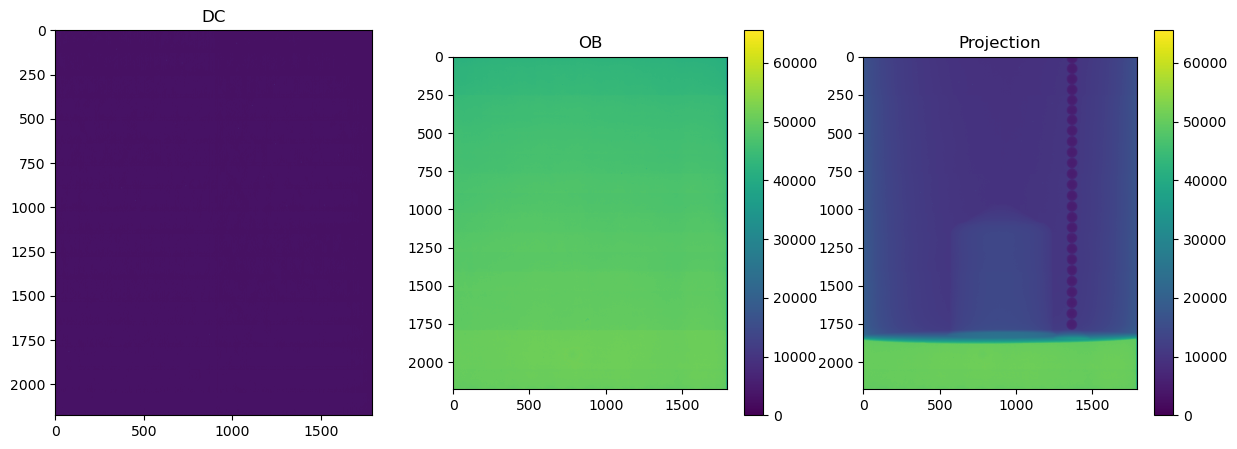

In [158]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
ax=ax.ravel()
ax[0].imshow(dc)
ax[0].set_title('DC')
a1=ax[1].imshow(ob)
fig.colorbar(a1,ax=ax[1])
ax[1].set_title('OB')
a2=ax[2].imshow(cal[1,:,:])
fig.colorbar(a2,ax=ax[2])
ax[2].set_title('Projection');

## Normalize projections

In [159]:
def normalizeData(img,ob,dc, flipProjection=False) :
    ob=ob-dc
    ob[ob<1]=1
    lcal=img.copy();
    for idx in np.arange(0, img.shape[0]):
        tmp=(img[idx,:,:]-dc)
        tmp[tmp<=0]=1
        lcal[idx,:,:]=(tmp/ob)
    lcal=-np.log(lcal)
    
    if flipProjection : 
        lcal = lcal[:,::-1,:]

    return lcal

(180, 2176, 1792)


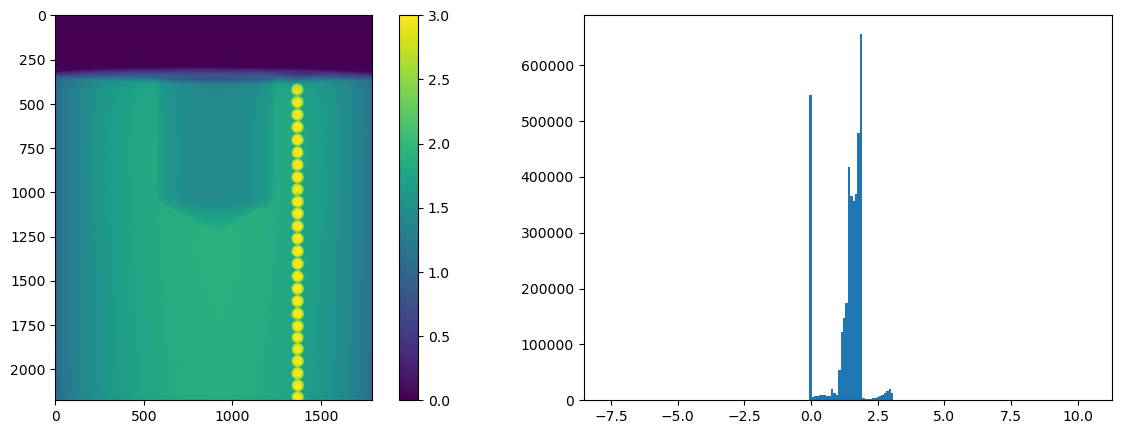

In [160]:
lcal=normalizeData(cal,ob,dc, flipProjection=True)

   
fig,ax=plt.subplots(1,2,figsize=(15,5))
im1 = ax[0].imshow(lcal[1],vmin=0,vmax=3)
fig.colorbar(im1, ax=ax[0], shrink=1)
ax[1].hist(lcal[1].ravel(),bins=200);
print(lcal.shape)


(180, 2176, 1792)


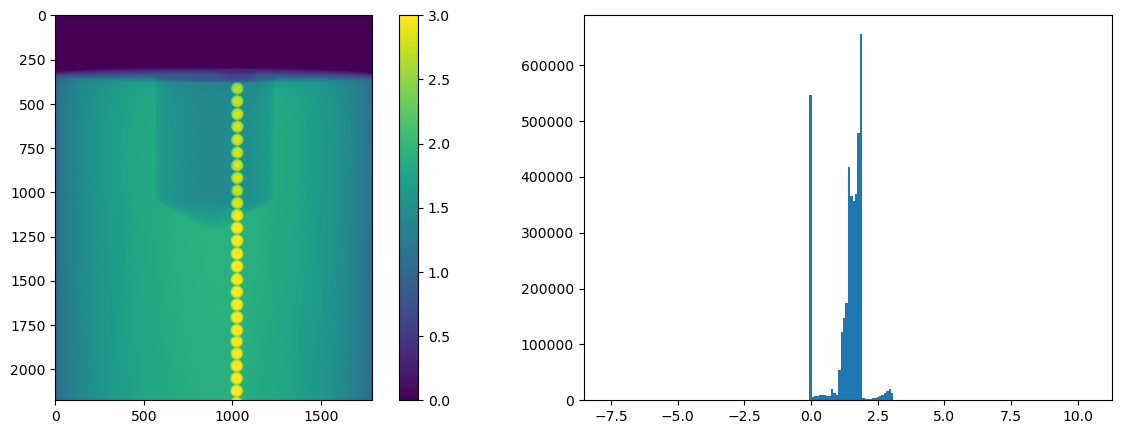

In [161]:
lcal = lcal[:,:,:]
print(lcal.shape)

fig,ax=plt.subplots(1,2,figsize=(15,5))
im1 = ax[0].imshow(lcal[16],vmin=0,vmax=3)
fig.colorbar(im1, ax=ax[0], shrink=1)
ax[1].hist(lcal[1].ravel(),bins=200);

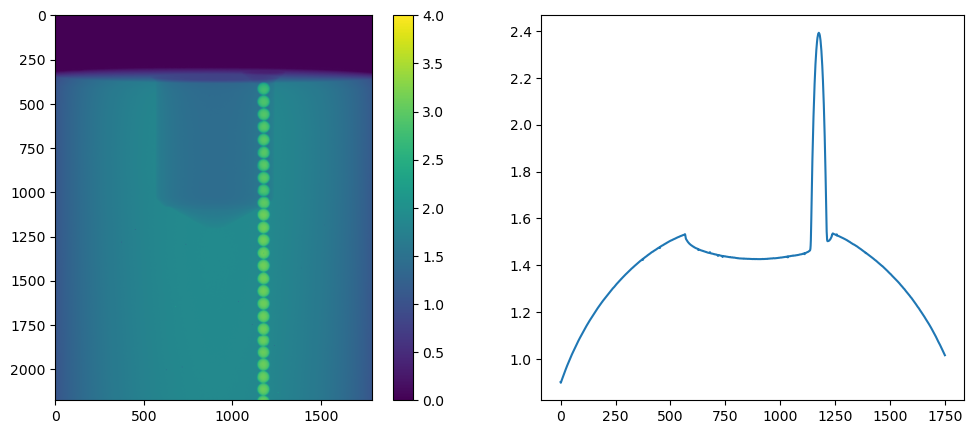

In [162]:
idx=10
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(lcal[idx,:,:],vmin=0,vmax=4)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[idx,:,:].mean(axis=0)[:1750])

In [163]:
print(lcal.shape)


(180, 2176, 1792)


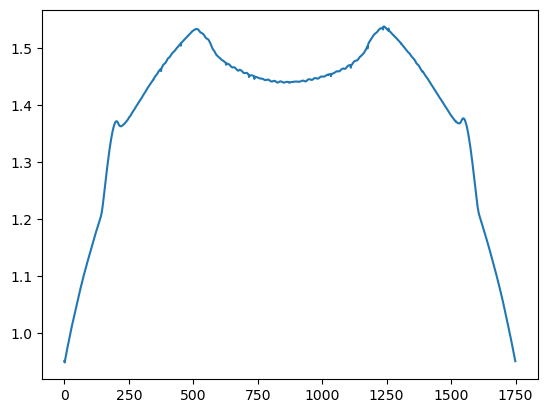

In [164]:
baseline = lcal.mean(axis=0).mean(axis=0)
baseline = baseline.reshape(1,baseline.shape[0])
plt.plot(baseline.ravel()[:1750])

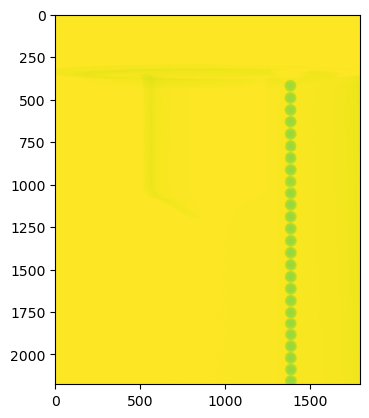

In [165]:
baseline = lcal.min(axis=0)

plt.imshow(baseline-lcal[0])

In [170]:
def removeBaseline(img, crop=None, usemin=False) :
    if crop is not None :
        img=img[:,:,crop[0]:crop[1]]

    if usemin :
        baseline = img.min(axis=0)
    else :
        baseline = img.mean(axis=0).mean(axis=0)
        baseline = baseline.reshape(1,baseline.shape[0])

        baseline=np.matmul(np.ones([img.shape[1],1]),baseline)
    
    res=img.copy()
    
    for idx in np.arange(0,res.shape[0]) :
        res[idx,:,:]=res[idx,:,:]-baseline

    return res

lcal=removeBaseline(lcal,usemin=False)

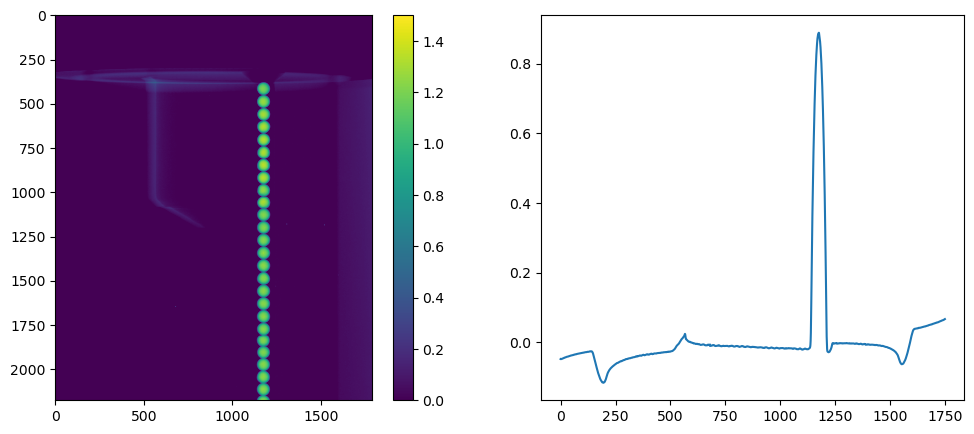

In [171]:
idx=10
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(lcal[idx,:,:],vmin=0,vmax=1.5)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[idx,:,:].mean(axis=0)[:1750])

In [172]:
# idx=0
# m = lcal.mean()
# s = lcal.std()
# k=0.93
# fig,ax=plt.subplots(1,3,figsize=[15,5])
# ax[0].hist(lcal.ravel(),bins=256)
# ax[0].vlines(m+k*s,ymin=0,ymax=5e7,color='r')
# im=ax[1].imshow(m+k*s < lcal[idx,:,:],interpolation='None')
# ax[2].plot(lcal[idx,:,:].mean(axis=0));
# ax[2].hlines(m+k*s,xmin=0, xmax=lcal.shape[2],color='r');

In [173]:
len(lcal)

180

In [174]:
lcal.shape

(180, 2176, 1792)

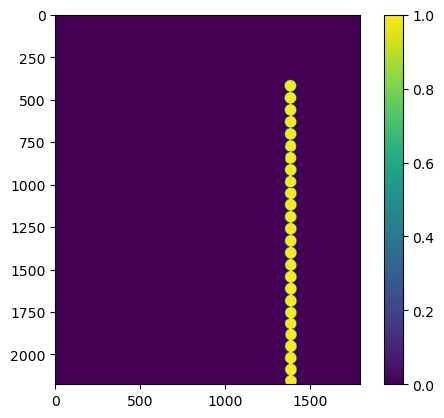

In [175]:
import cv2
import numpy as np

img = lcal
# Simple thresholding 
thresh_value =0.48

max_value = 1
thresh_type= cv2.THRESH_BINARY
thresh_img = []
for i in range(len(img)):
    thresh_type = cv2.THRESH_BINARY
    ret, thresh_img1 = cv2.threshold(img[i,:,:], thresh_value, max_value, thresh_type)
    thresh_img.append(thresh_img1)
#ret: The threshold value that was used to separate the foreground from the background. This value can be useful for further analysis or tuning of the thresholding operation.
thresh_img = np.array(thresh_img)


fig,ax=plt.subplots()
im1 = ax.imshow(thresh_img[0,:,:],vmin=0,vmax=1)
fig.colorbar(im1, ax=ax, shrink=1)


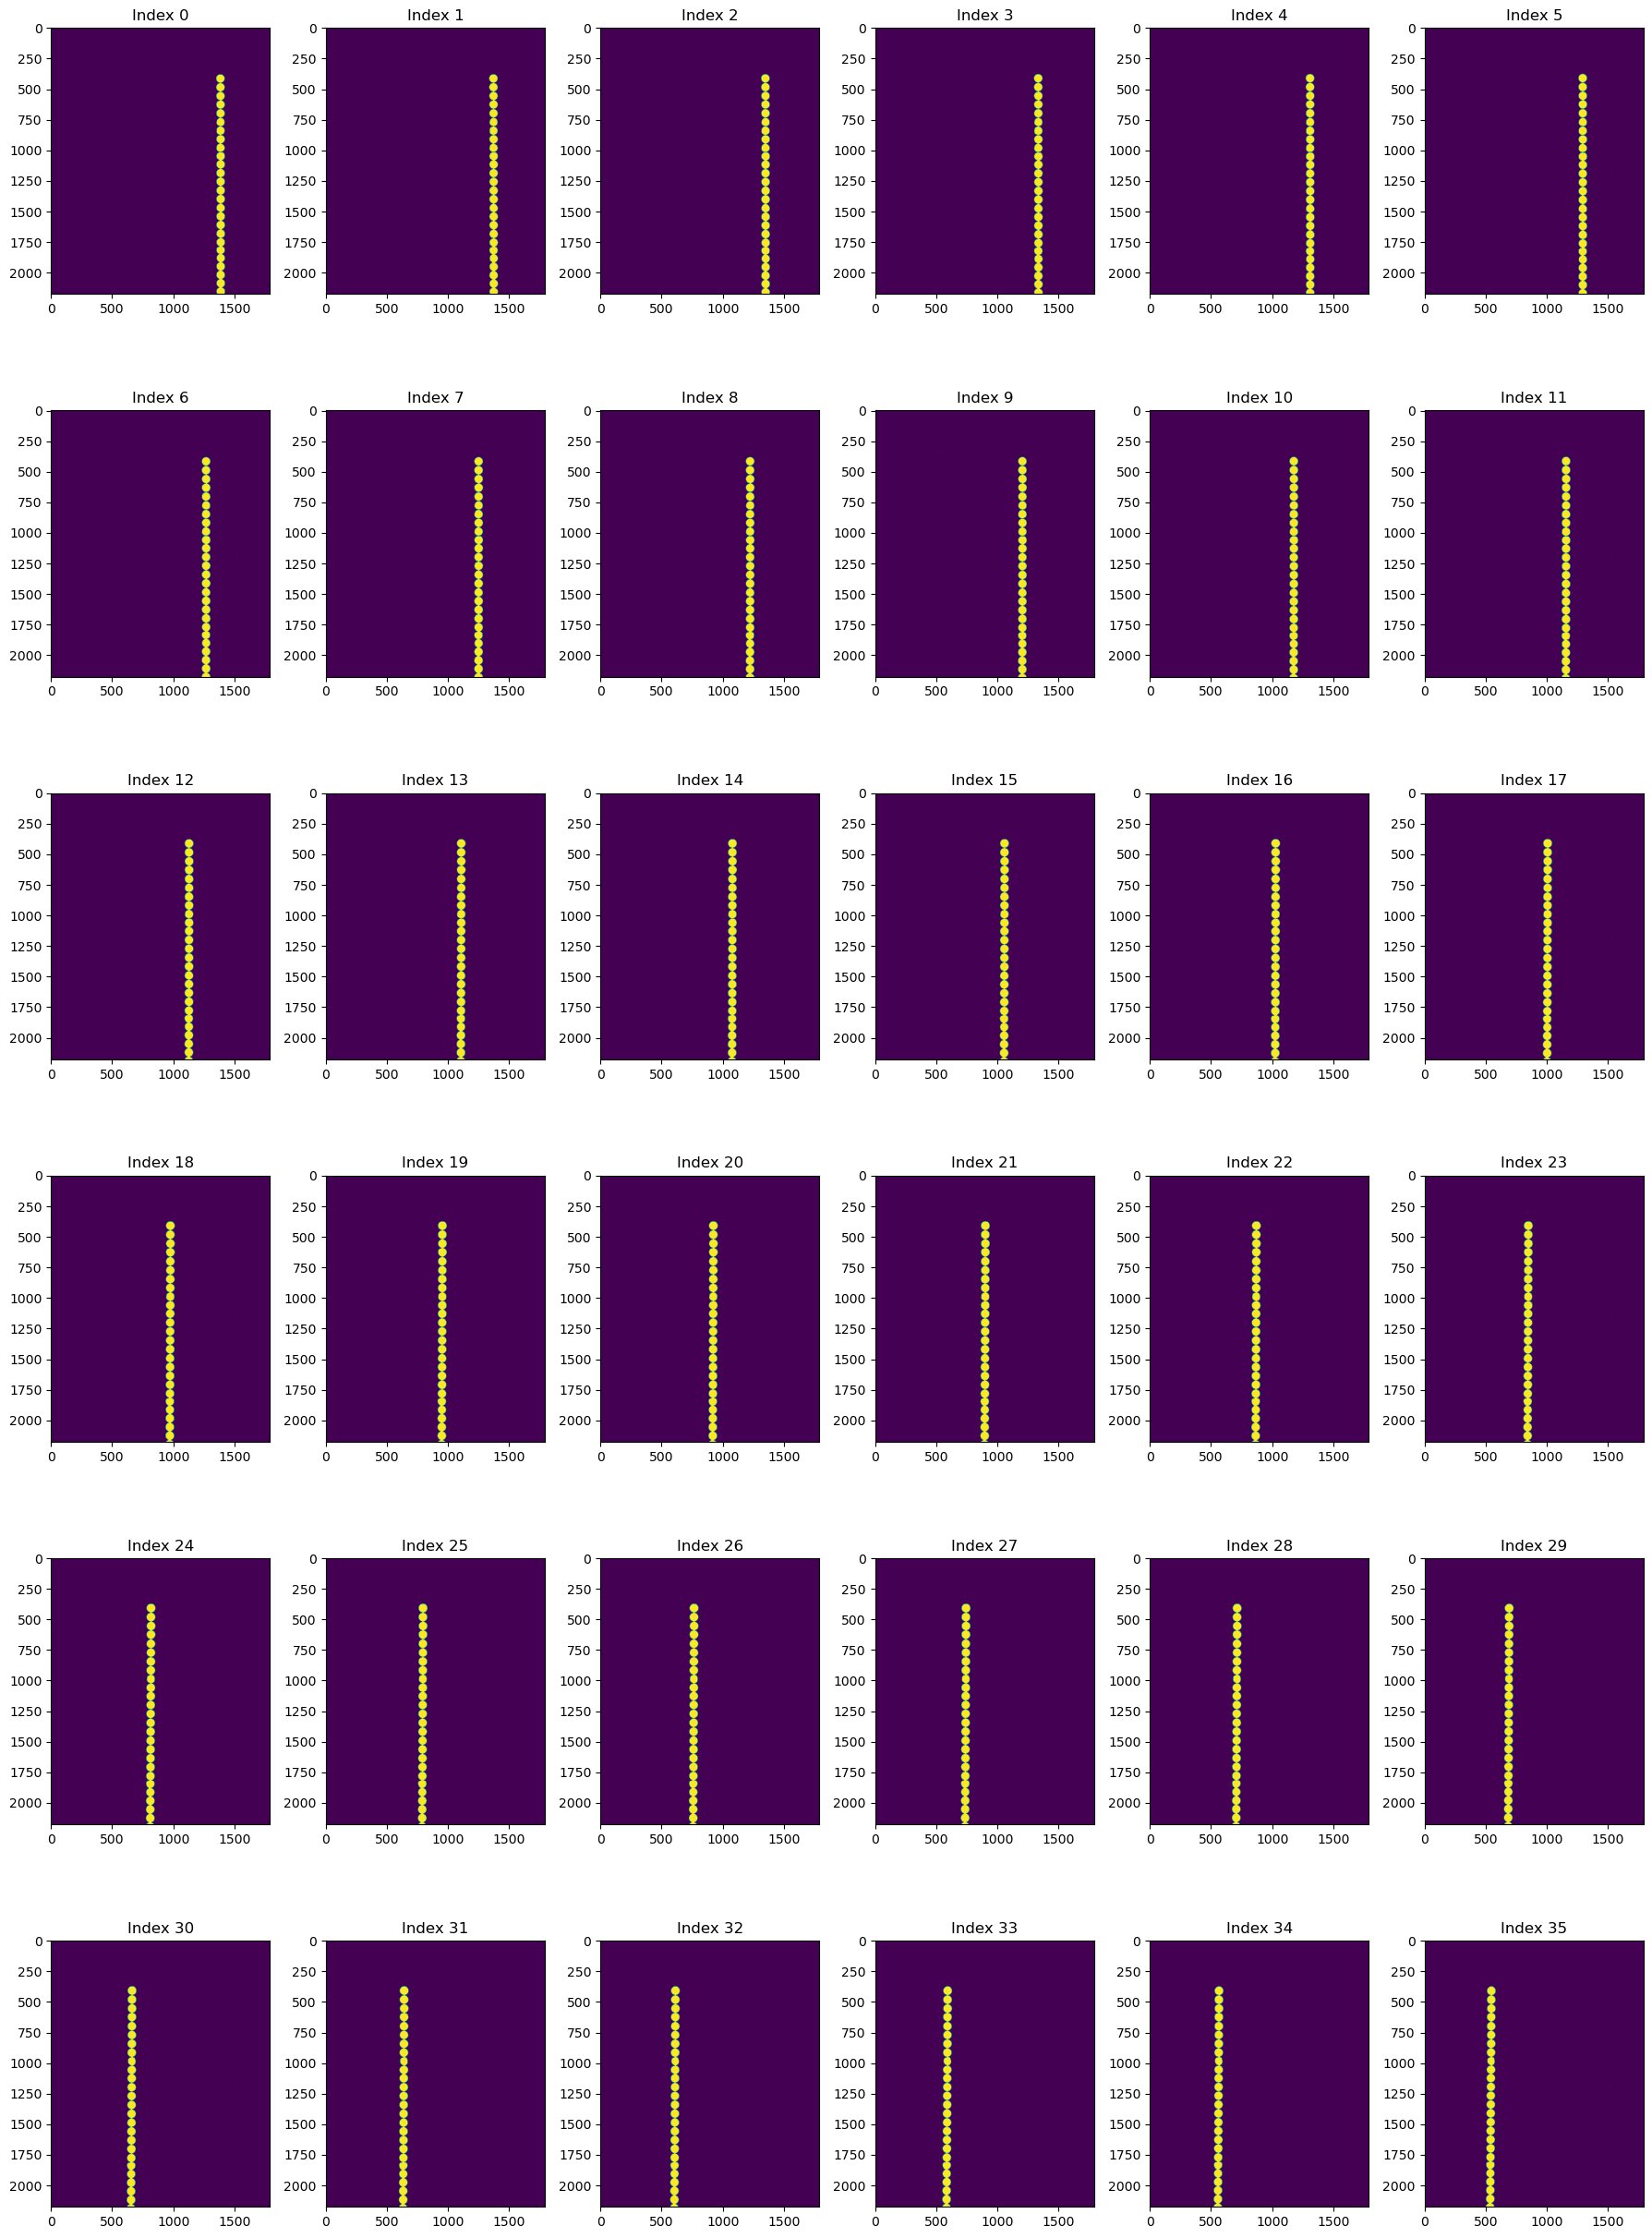

In [176]:

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 25))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(thresh_img[i, :, :], vmin=0, vmax=1)
#     ax.axhline(y=250, color='white', linestyle='--')  # Add a horizontal line at y=250
    ax.set_title(f'Index {i}')  # Set a title for each subplot
#     fig.colorbar(im, ax=ax, shrink=0.6)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [177]:
thresh_img.shape

(180, 2176, 1792)

In [178]:
len(thresh_img)

180

In [179]:
import numpy as np
print(np.__version__)


1.26.4


In [180]:
import matplotlib
print(matplotlib.__version__)


3.8.0


In [181]:
# Define the structuring element for erosion and dilation
kernel_size = 3
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

eroded_img  = np.zeros(thresh_img.shape)
dilated_img = np.zeros(thresh_img.shape)
for i in range(len(thresh_img)):
    # Perform erosion to remove small noise
    erosion_iterations = 14
    eroded_img[i] = cv2.erode(thresh_img[i], kernel, iterations=erosion_iterations)

    # Perform dilation to fill small gaps
    dilation_iterations = 1
    dilated_img[i] = cv2.dilate(eroded_img[i], kernel, iterations=dilation_iterations)


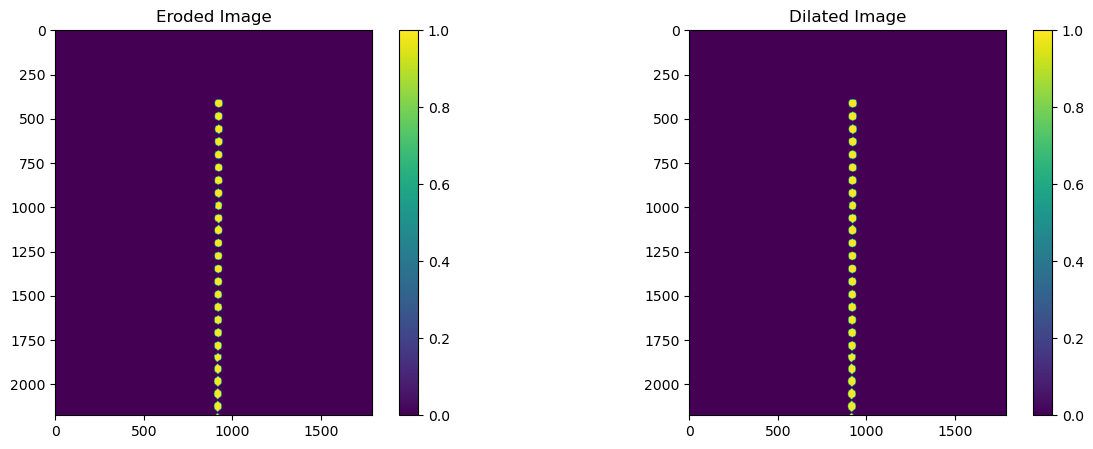

In [182]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
im1 = ax[0].imshow(eroded_img[20,:,:],vmin=0,vmax=1)
fig.colorbar(im1, ax=ax[0], shrink=1)
ax[0].set_title('Eroded Image');
im2 = ax[1].imshow(dilated_img[20,:,:],vmin=0,vmax=1)
fig.colorbar(im2, ax=ax[1], shrink=1)
ax[1].set_title('Dilated Image');


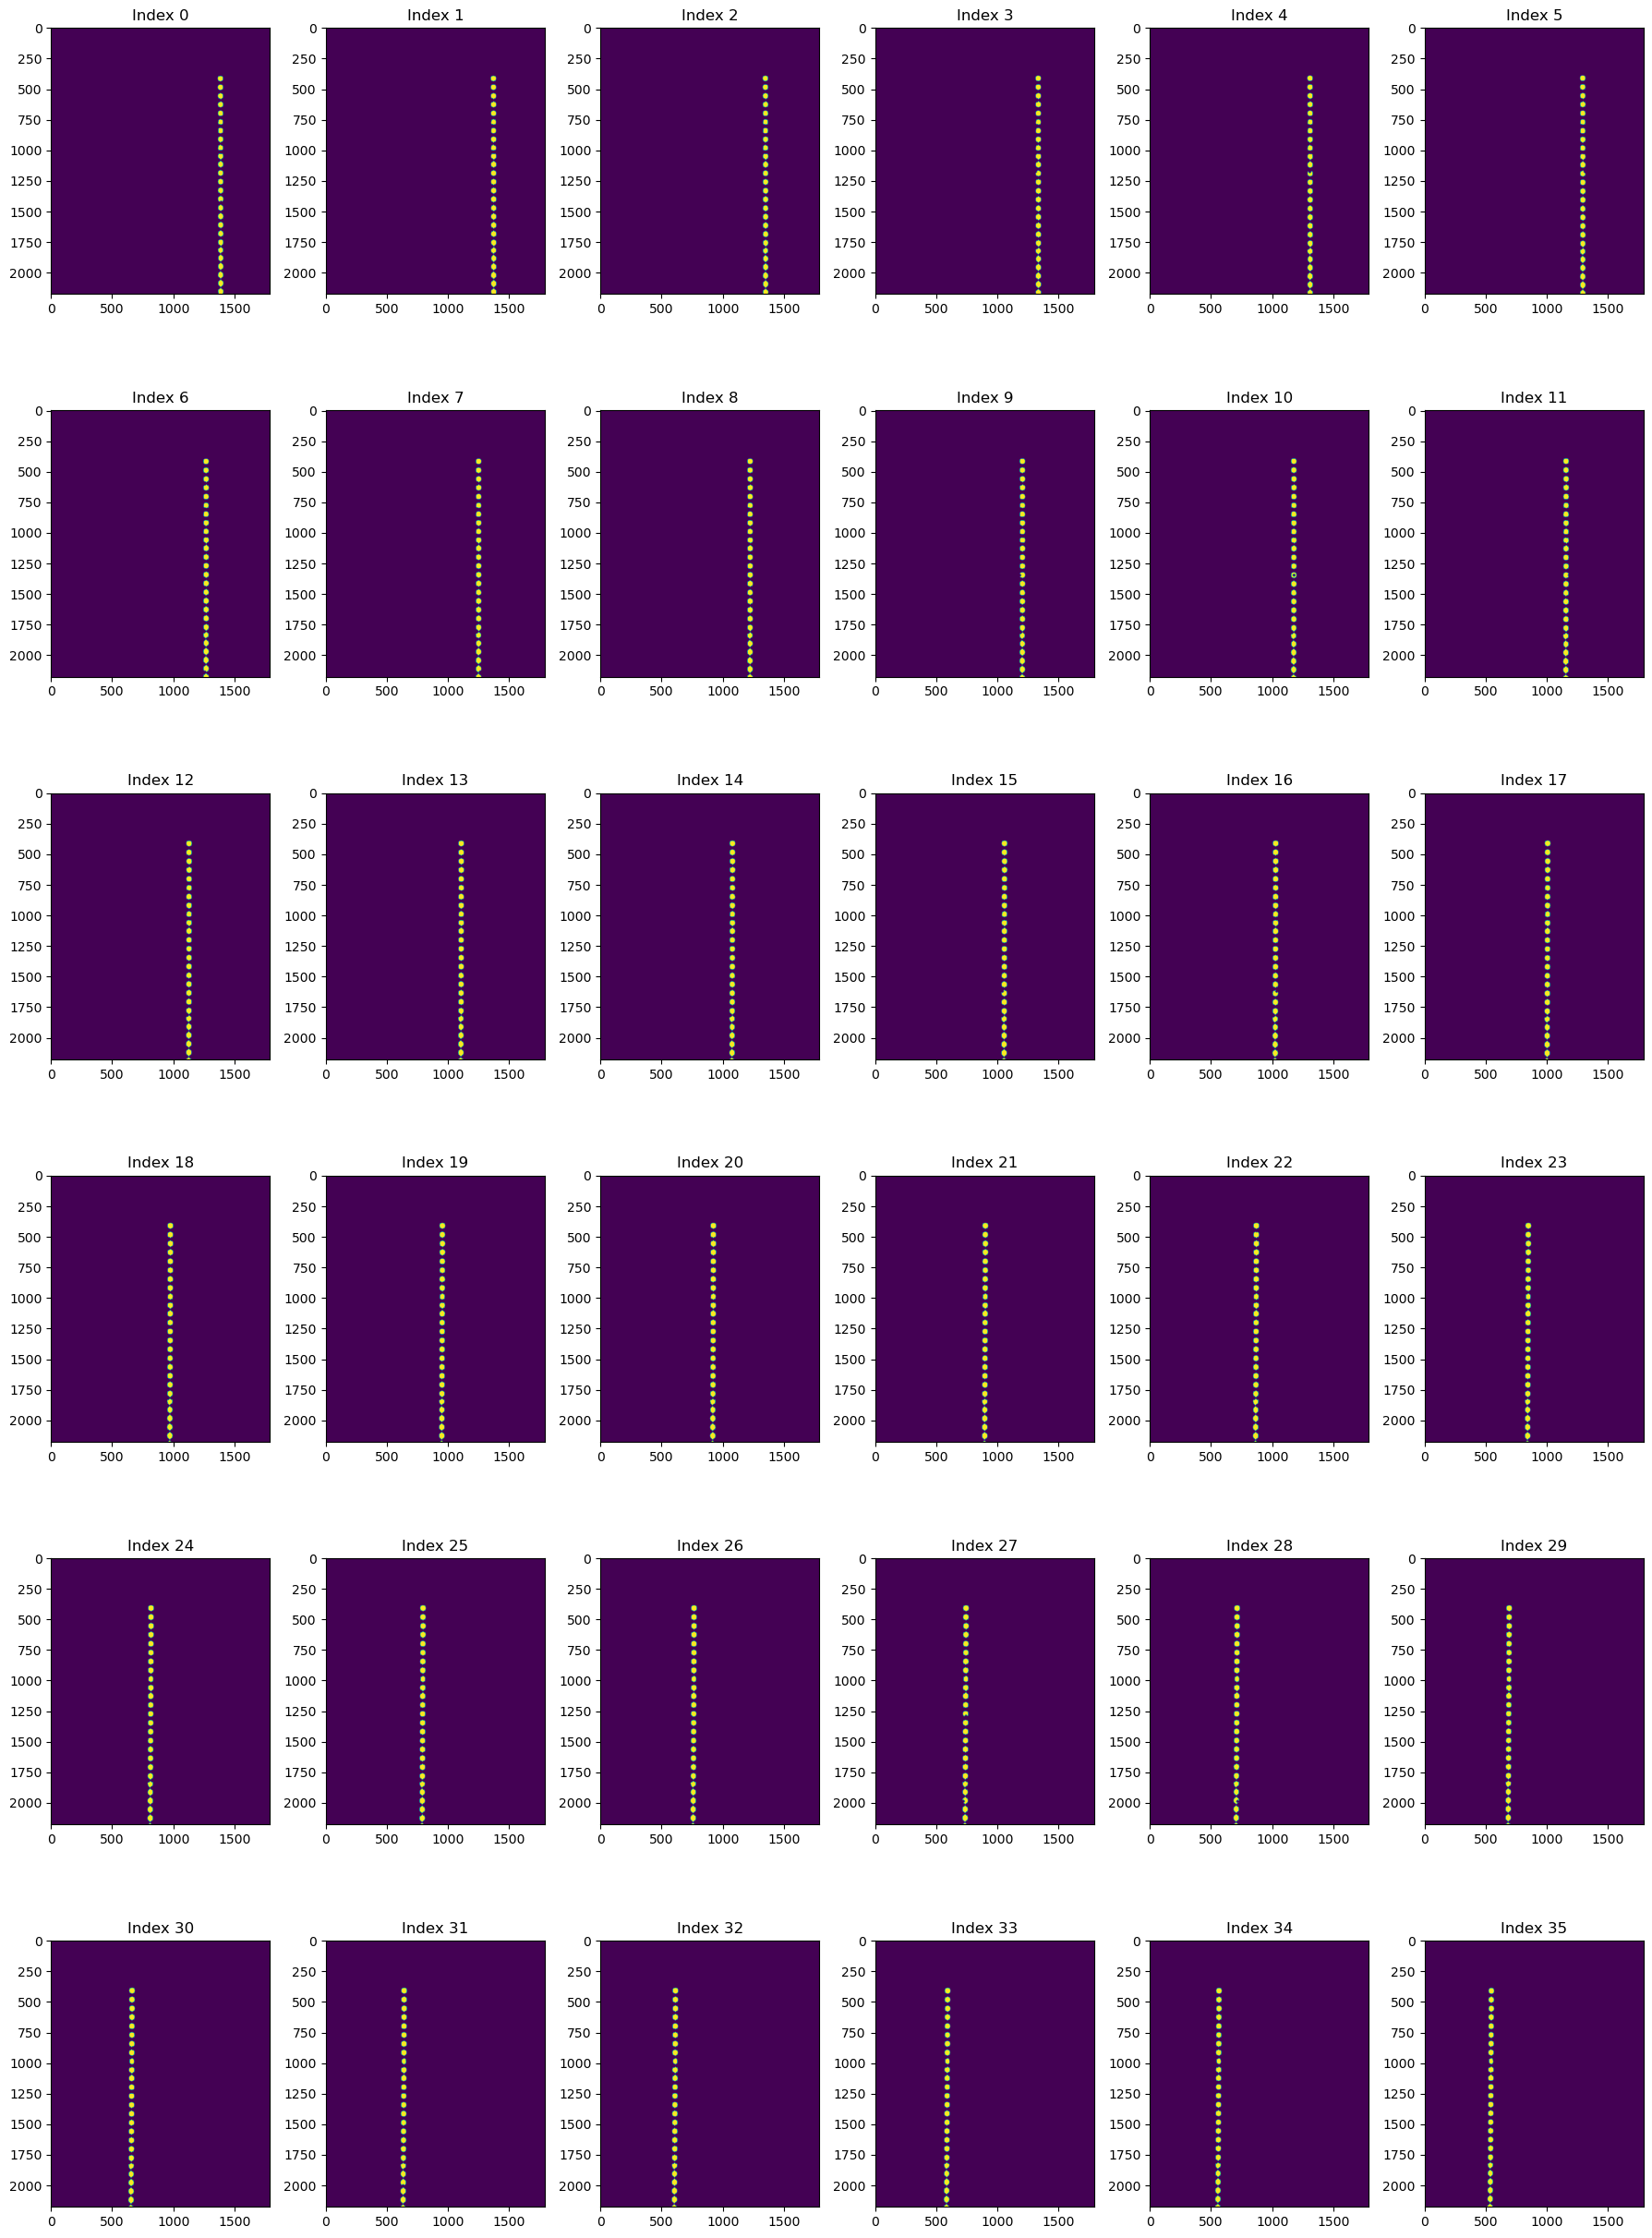

In [183]:

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(18, 25))

for i, ax in enumerate(axes.flat):
    im = ax.imshow(dilated_img[i, :, :], vmin=0, vmax=1)
#     ax.axhline(y=250, color='white', linestyle='--')  # Add a horizontal line at y=250
    ax.set_title(f'Index {i}')  # Set a title for each subplot
#     fig.colorbar(im, ax=ax, shrink=0.6)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


In [184]:
dilated_img.shape

(180, 2176, 1792)

In [185]:
# Perform connected component labeling on the first image
ret, labels = cv2.connectedComponents(dilated_img[0,:,:].astype(np.uint8))
num_beads = ret - 1
bead_ids = np.arange(1, num_beads + 1)
print(num_beads)
print(bead_ids.shape)

26
(26,)


In [186]:
bead_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [187]:
# # Perform connected component labeling on the first image
# ret1, labels1 = cv2.connectedComponents(dilated_img[1,:,:].astype(np.uint8))
# num_beads1 = ret1 - 1
# bead_ids1 = np.arange(1, num_beads1 + 1)
# print(num_beads1)
# print(bead_ids1.shape)

In [188]:
# bead_ids1

In [189]:
# fig,ax=plt.subplots(1,2,figsize=(15,5))
# im1 = ax[0].imshow(eroded_img[2,:,:],vmin=0,vmax=1)
# fig.colorbar(im1, ax=ax[0], shrink=1)
# im2 = ax[1].imshow(dilated_img[20,:,:],vmin=0,vmax=1)
# fig.colorbar(im2, ax=ax[1], shrink=1)

In [190]:
# Perform connected component labeling on the first image
ret2, labels2 = cv2.connectedComponents(dilated_img[0,:,:].astype(np.uint8))
num_beads2 = ret2 - 1
bead_ids2 = np.arange(1, num_beads2 + 1)
print(num_beads2)
print(bead_ids2.shape)

26
(26,)


In [191]:
bead_ids2

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

In [192]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Find the contours of the beads in the first image
contours, _ = cv2.findContours(dilated_img[0].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Compute the center of mass of each contour using its moments
bead_positions = []
for i, contour in enumerate(contours):
    moments = cv2.moments(contour)
    cx = int(moments['m10'] / moments['m00']+0.00001)
    cy = int(moments['m01'] / moments['m00']+0.00001)
    bead_positions.append([cy, cx])

# Fit a line to the bead positions using PCA
cov = np.cov(np.array(bead_positions).T)
eigenvalues, eigenvectors = np.linalg.eig(cov)
line_dir = eigenvectors[:, np.argmax(eigenvalues)]
mean_pos = np.mean(bead_positions, axis=0)
x1 = int(mean_pos[1] - 1000 * line_dir[1])
y1 = int(mean_pos[0] - 1000 * line_dir[0])
x2 = int(mean_pos[1] + 1000 * line_dir[1])
y2 = int(mean_pos[0] + 1000 * line_dir[0])

# Compute the intersection of each bead with the line
bead_intersections = []
for i, bead_pos in enumerate(bead_positions):
    # Compute the projection of the bead onto the line
    a = np.array([x1, y1])
    b = np.array([x2, y2])
    p = np.array(bead_pos)
    ap = p - a
    ab = b - a
    proj = a + np.dot(ap, ab) / np.dot(ab, ab) * ab

    # Compute the distance from the projection to the bead
    dist = np.linalg.norm(p - proj)

    # If the distance is small enough, use the projection as the intersection point
    if dist < 10:
        bead_intersections.append(proj)
    else:
        # Otherwise, use the bead position as the intersection point
        bead_intersections.append(bead_pos)

# Convert the bead intersections to a NumPy array
bead_intersections = np.array(bead_intersections)

# Assign unique IDs to each bead
num_beads = len(bead_positions)
bead_ids = np.arange(1, num_beads + 1)

print(f"Detected {num_beads} beads with IDs {bead_ids}")
print(f"Bead positions: {bead_positions}")
print(f"Bead intersections: {bead_intersections}")

# # Draw the contours and bead positions on the first image
# contour_img = cv2.cvtColor(dilated_img[0], cv2.COLOR_GRAY2BGR)
# cv2.drawContours(contour_img, contours, -1, (0, 0, 1), 2)
# for i, bead_pos in enumerate(bead_positions):
#     cv2.circle(contour_img, tuple(bead_pos[::-1]), 10, (0, 0, 1), -1)
#     cv2.circle(contour_img, tuple(bead_intersections[i,::-1].astype(int)), 10, (0, 1, 0), -1)

    

# # Show the result
# plt.imshow(contour_img)
# plt.show


Detected 26 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Bead positions: [[2155, 1385], [2090, 1385], [2022, 1384], [1952, 1385], [1884, 1385], [1820, 1384], [1757, 1385], [1685, 1385], [1614, 1384], [1544, 1384], [1474, 1384], [1401, 1384], [1333, 1384], [1262, 1384], [1191, 1384], [1120, 1384], [1055, 1384], [985, 1383], [916, 1384], [845, 1384], [775, 1384], [704, 1383], [633, 1384], [563, 1383], [492, 1382], [421, 1382]]
Bead intersections: [[2155 1385]
 [2090 1385]
 [2022 1384]
 [1952 1385]
 [1884 1385]
 [1820 1384]
 [1757 1385]
 [1685 1385]
 [1614 1384]
 [1544 1384]
 [1474 1384]
 [1401 1384]
 [1333 1384]
 [1262 1384]
 [1191 1384]
 [1120 1384]
 [1055 1384]
 [ 985 1383]
 [ 916 1384]
 [ 845 1384]
 [ 775 1384]
 [ 704 1383]
 [ 633 1384]
 [ 563 1383]
 [ 492 1382]
 [ 421 1382]]


In [193]:
bp = np.array(bead_positions)

In [194]:
bp.shape

(26, 2)

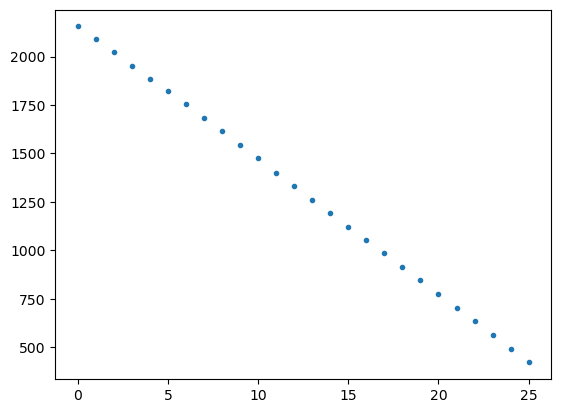

In [195]:
plt.plot(bp[:,0], '.')

In [196]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Sensitivity threshold for detecting beads
sensitivity = 0.2

# Loop over all the projections
for i in [0, 9, 19, 29]:

    # Find the contours of the beads in the current image
    contours, _ = cv2.findContours(dilated_img[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Compute the center of mass of each contour using its moments
    bead_positions = []
    for j, contour in enumerate(contours):
        moments = cv2.moments(contour)
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            bead_positions.append([cy, cx])

    # Fit a line to the bead positions using PCA
    cov = np.cov(np.array(bead_positions).T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    line_dir = eigenvectors[:, np.argmax(eigenvalues)]
    mean_pos = np.mean(bead_positions, axis=0)
    x1 = int(mean_pos[1] - 1000 * line_dir[1])
    y1 = int(mean_pos[0] - 1000 * line_dir[0])
    x2 = int(mean_pos[1] + 1000 * line_dir[1])
    y2 = int(mean_pos[0] + 1000 * line_dir[0])

    # Compute the intersection of each bead with the line
    bead_intersections = []
    for j, bead_pos in enumerate(bead_positions):
        # Compute the projection of the bead onto the line
        a = np.array([x1, y1])
        b = np.array([x2, y2])
        p = np.array(bead_pos)
        ap = p - a
        ab = b - a
        proj = a + np.dot(ap, ab) / np.dot(ab, ab) * ab

        # Compute the distance from the projection to the bead
        dist = np.linalg.norm(p - proj)

        # If the distance is small enough, use the projection as the intersection point
        if dist < sensitivity * np.linalg.norm(bead_pos - mean_pos):
            bead_intersections.append(proj)
        else:
            # Otherwise, use the bead position as the intersection point
            bead_intersections.append(bead_pos)

    # Convert the bead intersections to a NumPy array
    bead_intersections = np.array(bead_intersections)

    # Assign unique IDs to each bead
    num_beads = len(bead_positions)
    bead_ids = np.arange(1, num_beads + 1)

    print(f"Detected {num_beads} beads with IDs {bead_ids}")
    print(f"Bead positions: {bead_positions}")
    print(f"Bead intersections: {bead_intersections}")

    # Draw the contours and bead positions on the current projection
    contour_img = cv2.cvtColor(dilated_img[i], cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_img, contours, -1, (0, 0, 1), 2)
    for j, bead_pos in enumerate(bead_positions):
        cv2.circle(contour_img, tuple(bead_pos[::-1]), 10, (0, 0, 1), -1)
#         cv2.circle(contour_img, tuple(bead_intersections[j,::-1].astype(np.int)), 10, (0, 1, 0), -1)
        cv2.circle(contour_img, tuple(bead_intersections[j,::-1].astype(int)), 10, (0, 1, 0), -1)


    # Show the result for some specific projections
    if i in [0, 9, 19, 29]:
        fig, ax = plt.subplots()
        ax.imshow(contour_img)
        ax.set_title(f"Projection {i+1}")
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        ax.set_aspect('equal', 'box')
        plt.show()


Detected 26 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Bead positions: [[2155, 1385], [2090, 1385], [2022, 1384], [1952, 1385], [1884, 1385], [1820, 1384], [1757, 1385], [1685, 1385], [1614, 1384], [1544, 1384], [1474, 1384], [1401, 1384], [1333, 1384], [1262, 1384], [1191, 1384], [1120, 1384], [1055, 1384], [985, 1383], [916, 1384], [845, 1384], [775, 1384], [704, 1383], [633, 1384], [563, 1383], [492, 1382], [421, 1382]]
Bead intersections: [[2155.         1385.        ]
 [2090.         1385.        ]
 [2022.         1384.        ]
 [1952.         1385.        ]
 [1884.         1385.        ]
 [1820.         1384.        ]
 [1757.         1385.        ]
 [1685.         1385.        ]
 [1614.         1384.        ]
 [1544.         1384.        ]
 [1474.         1384.        ]
 [1383.63353907 1384.02604969]
 [1333.         1384.        ]
 [1262.         1384.        ]
 [1191.         1384.        ]
 [1120.         1384.        ]
 [10

error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


In [197]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Sensitivity threshold for detecting beads
sensitivity = 0.2

# Find the contours and intersections of the beads in each projection
bead_positions_all = []
bead_intersections_all = []
for i in range(dilated_img.shape[0]):
    # Find the contours of the beads in the current projection
    contours, _ = cv2.findContours(dilated_img[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Compute the center of mass of each contour using its moments
    bead_positions = []
    for j, contour in enumerate(contours):
        moments = cv2.moments(contour)
        if moments['m00'] == 0:
            continue
        cx = int(moments['m10'] / moments['m00']+0.000001)
        cy = int(moments['m01'] / moments['m00']+0.000001)
        bead_positions.append([cy, cx])

    # Fit a line to the bead positions using PCA
    cov = np.cov(np.array(bead_positions).T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    line_dir = eigenvectors[:, np.argmax(eigenvalues)]
    mean_pos = np.mean(bead_positions, axis=0)
    x1 = int(mean_pos[1] - 1000 * line_dir[1])
    y1 = int(mean_pos[0] - 1000 * line_dir[0])
    x2 = int(mean_pos[1] + 1000 * line_dir[1])
    y2 = int(mean_pos[0] + 1000 * line_dir[0])

    # Compute the intersection of each bead with the line
    bead_intersections = []
    for j, bead_pos in enumerate(bead_positions):
        # Compute the projection of the bead onto the line
        a = np.array([x1, y1])
        b = np.array([x2, y2])
        p = np.array(bead_pos)
        ap = p - a
        ab = b - a
        proj = a + np.dot(ap, ab) / np.dot(ab, ab) * ab

        # Compute the distance from the projection to the bead
        dist = np.linalg.norm(p - proj)

        # If the distance is small enough, use the projection as the intersection point
        if dist < sensitivity:
            bead_intersections.append(proj)
        else:
            # Otherwise, use the bead position as the intersection point
            bead_intersections.append(bead_pos)

    bead_positions_all.append(bead_positions)
    bead_intersections_all.append(bead_intersections)

    # Convert the bead intersections to a NumPy array
    bead_intersections = np.array(bead_intersections)

    # Assign unique IDs to each bead
    num_beads = len(bead_positions)
    bead_ids = np.arange(1, num_beads + 1)

    print(f"Detected {num_beads} beads with IDs {bead_ids}")
    print(f"Bead positions: {bead_positions}")
    print(f"Bead intersections: {bead_intersections}")

    # Show the result for some specific projections
    # if i in [0, 9, 19, 29]:
    #     fig, ax = plt.subplots()
    #     ax.imshow(contour_img)
    #     ax.set_title(f"Projection {i+1}")
    #     ax.set_xlabel('X position')
    #     ax.set_ylabel('Y position')
    #     ax.set_aspect('equal', 'box')
    #     plt.show()


    

Detected 26 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Bead positions: [[2155, 1385], [2090, 1385], [2022, 1384], [1952, 1385], [1884, 1385], [1820, 1384], [1757, 1385], [1685, 1385], [1614, 1384], [1544, 1384], [1474, 1384], [1401, 1384], [1333, 1384], [1262, 1384], [1191, 1384], [1120, 1384], [1055, 1384], [985, 1383], [916, 1384], [845, 1384], [775, 1384], [704, 1383], [633, 1384], [563, 1383], [492, 1382], [421, 1382]]
Bead intersections: [[2155 1385]
 [2090 1385]
 [2022 1384]
 [1952 1385]
 [1884 1385]
 [1820 1384]
 [1757 1385]
 [1685 1385]
 [1614 1384]
 [1544 1384]
 [1474 1384]
 [1401 1384]
 [1333 1384]
 [1262 1384]
 [1191 1384]
 [1120 1384]
 [1055 1384]
 [ 985 1383]
 [ 916 1384]
 [ 845 1384]
 [ 775 1384]
 [ 704 1383]
 [ 633 1384]
 [ 563 1383]
 [ 492 1382]
 [ 421 1382]]
Detected 26 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Bead positions: [[2157, 1367], [2093, 1367], [2024, 1

In [199]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Sensitivity threshold for detecting beads
sensitivity = 0.7

# Find the contours and intersections of the beads in each projection
bead_positions_all = []
bead_intersections_all = []
bead_ids_all = []
for i in range(dilated_img.shape[0]):
    # Find the contours of the beads in the current projection
    contours, _ = cv2.findContours(dilated_img[i].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Compute the center of mass of each contour using its moments
    bead_positions = []
    for j, contour in enumerate(contours):
        moments = cv2.moments(contour)
        if moments['m00'] == 0:
            continue
        cx = int(moments['m10'] / moments['m00']+0.000001)
        cy = int(moments['m01'] / moments['m00']+0.000001)
        bead_positions.append([cy, cx])


    # Fit a line to the bead positions using PCA
    cov = np.cov(np.array(bead_positions).T)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    line_dir = eigenvectors[:, np.argmax(eigenvalues)]
    mean_pos = np.mean(bead_positions, axis=0)
    x1 = int(mean_pos[1] - 1000 * line_dir[1])
    y1 = int(mean_pos[0] - 1000 * line_dir[0])
    x2 = int(mean_pos[1] + 1000 * line_dir[1])
    y2 = int(mean_pos[0] + 1000 * line_dir[0])

    # Compute the intersection of each bead with the line
    bead_intersections = []
    bead_ids = []
    for j, bead_pos in enumerate(bead_positions):
        # Compute the projection of the bead onto the line
        a = np.array([x1, y1])
        b = np.array([x2, y2])
        p = np.array(bead_pos)
        ap = p - a
        ab = b - a
        proj = a + np.dot(ap, ab) / np.dot(ab, ab) * ab

        # Compute the distance from the projection to the bead
        dist = np.linalg.norm(p - proj)

        # If the distance is small enough, use the projection as the intersection point
        if dist < sensitivity:
            bead_intersections.append(proj)
        else:
            # Otherwise, use the bead position as the intersection point
            bead_intersections.append(bead_pos)

        # Append the bead ID to the list
        bead_ids.append(j+1)

    bead_positions_all.append(bead_positions)
    bead_intersections_all.append(bead_intersections)
    bead_ids_all.append(bead_ids)
    
    # Assign unique IDs to each bead
    num_beads = len(bead_positions)
    bead_ids = np.arange(1, num_beads + 1)

    print(f"Detected {num_beads} beads with IDs {bead_ids}")
    print(f"Bead positions: {bead_positions}")
    print(f"Bead intersections: {bead_intersections}")

    # Show the result for some specific projections
    # if i in [0, 9, 19, 29]:
    #     fig, ax = plt.subplots()
    #     ax.imshow(contour_img)
    #     ax.set_title(f"Projection {i+1}")
    #     ax.set_xlabel('X position')
    #     ax.set_ylabel('Y position')
    #     ax.set_aspect('equal', 'box')
    #     plt.show()


Detected 26 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Bead positions: [[2155, 1385], [2090, 1385], [2022, 1384], [1952, 1385], [1884, 1385], [1820, 1384], [1757, 1385], [1685, 1385], [1614, 1384], [1544, 1384], [1474, 1384], [1401, 1384], [1333, 1384], [1262, 1384], [1191, 1384], [1120, 1384], [1055, 1384], [985, 1383], [916, 1384], [845, 1384], [775, 1384], [704, 1383], [633, 1384], [563, 1383], [492, 1382], [421, 1382]]
Bead intersections: [[2155, 1385], [2090, 1385], [2022, 1384], [1952, 1385], [1884, 1385], [1820, 1384], [1757, 1385], [1685, 1385], [1614, 1384], [1544, 1384], [1474, 1384], [1401, 1384], [1333, 1384], [1262, 1384], [1191, 1384], [1120, 1384], [1055, 1384], [985, 1383], [916, 1384], [845, 1384], [775, 1384], [704, 1383], [633, 1384], [563, 1383], [492, 1382], [421, 1382]]
Detected 26 beads with IDs [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
Bead positions: [[2157, 1367], [2093

In [200]:
# Find unique lengths of the sublists
unique_lengths = set(len(sublist) for sublist in bead_positions_all)

print(f"Unique lengths of sublists: {unique_lengths}")


Unique lengths of sublists: {26, 27, 28, 29, 30}


In [201]:
## Let's assume the most common length is the one you want
# desired_length = min(unique_lengths)  # This might need modification

# bead_positions_all = [sublist for sublist in bead_positions_all if len(sublist) == desired_length]


In [202]:
# # Pad with a default value (e.g., -1) or trim to the desired length
# desired_length = max(unique_lengths)  # This might need modification

# def modify_sublist(sublist, length, default_value=1):
#     if len(sublist) < length:
#         return sublist + [default_value] * (length - len(sublist))
#     else:
#         return sublist[:length]

# bead_positions_all = [modify_sublist(sublist, desired_length) for sublist in bead_positions_all]


In [203]:
# # Find unique lengths of the sublists
# min_length = min(unique_lengths)

# # Filter the main list
# bead_positions_all = [sublist for sublist in bead_positions_all if len(sublist) >= min_length]


In [204]:
# # Find the length of the longest sublist
# max_length = max(len(sublist) for sublist in bead_positions_all)

# # Keep only those sublists that match the length of the longest sublist
# bead_positions_all = [sublist for sublist in bead_positions_all if len(sublist) == max_length]

# # Now, you should be able to convert it to a numpy array
# bead_positions_all = np.array(bead_positions_all)


In [205]:
# # Find the length of the longest sublist
# max_length = max(len(sublist) for sublist in bead_intersections_all)

# # Keep only those sublists that match the length of the longest sublist
# bead_intersections_all = [sublist for sublist in bead_intersections_all if len(sublist) == max_length]

# # Now, you should be able to convert it to a numpy array
# bead_intersections_all = np.array(bead_intersections_all)


In [206]:
# # Find the length of the longest sublist
# max_length = max(len(sublist) for sublist in bead_positions_all)

# # Keep only those sublists that match the length of the longest sublist
# bead_positions_all = [sublist for sublist in bead_positions_all if len(sublist) == max_length]

# # Now, you should be able to convert it to a numpy array
# bead_positions_all = np.array(bead_positions_all)


In [207]:
# # 1. Find the length of the longest sublist
# max_length = max(len(sublist) for sublist in bead_positions_all)

# # 2. Find the indices of sublists that are shorter than the longest list
# short_indices = [i for i, sublist in enumerate(bead_positions_all) if len(sublist) != max_length]

# # 3. Remove corresponding entries from all three lists
# # Remove the sublists from bead_positions_all
# bead_positions_all = [bead_positions_all[i] for i in range(len(bead_positions_all)) if i not in short_indices]

# # Remove the sublists from bead_intersections_all
# bead_intersections_all = [bead_intersections_all[i] for i in range(len(bead_intersections_all)) if i not in short_indices]

# # Remove the sublists from bead_ids_all
# bead_ids_all = [bead_ids_all[i] for i in range(len(bead_ids_all)) if i not in short_indices]


# # Convert the lists to NumPy arrays with dtype=object for flexibility
# bead_positions_all = np.array(bead_positions_all, dtype=object)
# bead_intersections_all = np.array(bead_intersections_all, dtype=object)
# bead_ids_all = np.array(bead_ids_all, dtype=object)

# # # Remove the entries
# # bead_positions_all_np = np.delete(bead_positions_all_np, short_indices)
# # bead_intersections_all_np = np.delete(bead_intersections_all_np, short_indices)
# # bead_ids_all_np = np.delete(bead_ids_all_np, short_indices)


In [211]:
# def pad_list(lst, target_length, padding_value):
#     # Convert numpy array to list if it's an array
#     lst = lst.tolist() if isinstance(lst, np.ndarray) else lst
#     return lst + [padding_value] * (target_length - len(lst))




# # Determine the max length
# max_len_positions = max(len(lst) for lst in bead_positions_all)
# max_len_intersections = max(len(lst) for lst in bead_intersections_all)
# max_len_ids = max(len(lst) for lst in bead_ids_all)

# # Pad lists to the same length
# bead_positions_all_padded = [pad_list_2d(lst, max_len_positions, [np.nan, np.nan]) for lst in bead_positions_all]
# bead_intersections_all_padded = [pad_list_2d(lst, max_len_intersections, [np.nan, np.nan]) for lst in bead_intersections_all]
# bead_ids_all_padded = [pad_list(lst, max_len_ids, np.nan) for lst in bead_ids_all]

# # Convert to arrays
bead_positions_all     = np.array(bead_positions_all)
bead_intersections_all = np.array(bead_intersections_all)
bead_ids_all           = np.array(bead_ids_all)



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (180,) + inhomogeneous part.

In [212]:
len(bead_positions_all)

180

In [213]:
bead_positions_all.shape

AttributeError: 'list' object has no attribute 'shape'

In [214]:
len(bead_intersections_all)

180

In [215]:
bead_intersections_all.shape

AttributeError: 'list' object has no attribute 'shape'

In [216]:
len(bead_ids_all)

180

In [217]:
bead_ids_all.shape

AttributeError: 'list' object has no attribute 'shape'

In [218]:
# Define the initial feature points as the bead positions in the first projection
feature_points = np.array(bead_positions_all[0], dtype=np.float32).reshape(-1, 1, 2)

# Define the Lucas-Kanade parameters
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Loop over each subsequent projection and track the feature points
trajectories = []
for i in range(1, dilated_img.shape[0]):
    # Convert the images to CV_8U format
    img1 = cv2.convertScaleAbs(dilated_img[i-1])
    img2 = cv2.convertScaleAbs(dilated_img[i])

    # Calculate the optical flow of the feature points from the previous frame to the current frame
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, feature_points, None, **lk_params)


    # Remove any feature points that were not tracked successfully
    st = st.reshape(-1)
    feature_points = feature_points[st == 1]
    p1 = p1[st == 1]

    # Detect new feature points in the current frame
    new_features = np.array(bead_positions_all[i], dtype=np.float32).reshape(-1, 1, 2)
    feature_points = np.vstack((feature_points, new_features))

    # Calculate the trajectories of the feature points up to the current frame
    trajectories.append(feature_points.reshape(-1, 2))

# Convert the trajectories to NumPy arrays
trajectories = np.array(trajectories)



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (179,) + inhomogeneous part.

In [219]:
trajectories.shape

AttributeError: 'list' object has no attribute 'shape'

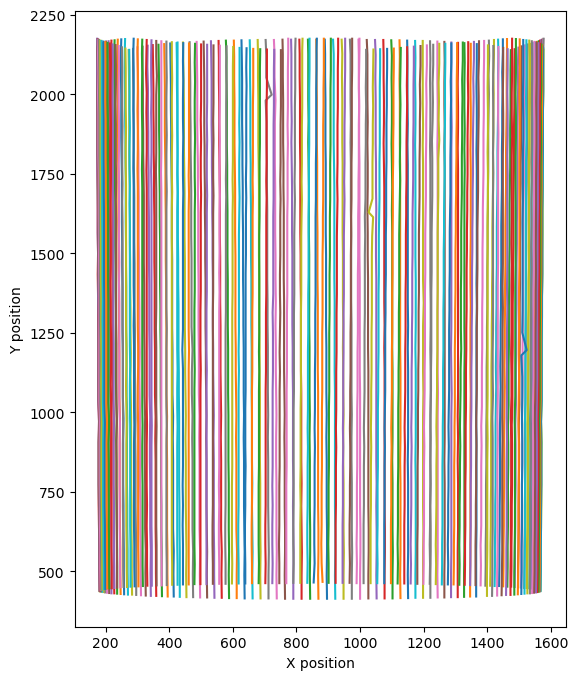

In [220]:
import matplotlib.pyplot as plt

# Plot the trajectories of the beads
fig, ax = plt.subplots(figsize=(8,8))
for traj in trajectories:
    ax.plot(traj[:, 1], traj[:, 0])
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_aspect('equal', 'box')
plt.show()


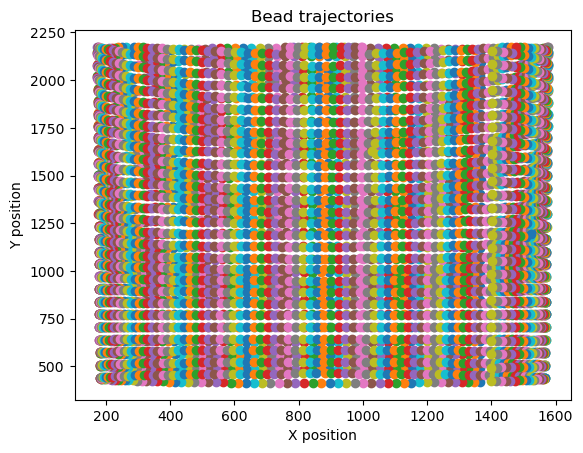

In [222]:
import matplotlib.pyplot as plt

# Loop over each bead and plot its trajectory
for i in range(len(trajectories)):
    y = trajectories[i][:, 0]
    x = trajectories[i][:, 1]
    plt.scatter(x, y, label=f"Bead {i+1}")

# Add plot labels and legend
plt.xlabel("X position")
plt.ylabel("Y position")
ax.set_aspect('equal', 'box')
plt.title("Bead trajectories")
# plt.legend()
plt.show()


In [223]:
# import matplotlib.pyplot as plt

# # Loop over each bead and plot its trajectory
# colors = plt.cm.jet(np.linspace(0, 1, len(trajectories)))  # define a color for each bead
# for i in range(len(trajectories)):
#     y = trajectories[i][:, 0]
#     x = trajectories[i][:, 1]
#     plt.plot(x, y, color=colors[i])
# plt.show()


In [224]:
len(trajectories)

179

In [225]:
len(bead_ids_all)

180

In [226]:
trajectories[:][0][:,0]

array([2157., 2093., 2024., 1955., 1887., 1822., 1759., 1687., 1616.,
       1546., 1476., 1404., 1334., 1263., 1192., 1120., 1055.,  985.,
        917.,  845.,  775.,  704.,  632.,  563.,  492.,  420.],
      dtype=float32)

In [227]:
bead_ids = np.array(bead_ids).reshape(-1,1)
bead_positions = np.array(bead_positions)

In [228]:
# dilated_img = dilated_img.astype(np.uint8)

# # Define the initial feature points as the bead positions in the first projection, along with their IDs
# feature_points = np.hstack((bead_positions_all[0], np.array(bead_ids_all[0]).reshape(-1, 1))).astype(np.float32).reshape(-1, 1, 3)

# # Define the Lucas-Kanade parameters
# lk_params = dict(winSize=(10, 10),
#                  maxLevel=2,
#                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# # Loop over each subsequent projection and track the feature points
# trajectories = {}
# for i in range(1, dilated_img.shape[0]):
#     # Calculate the optical flow of the feature points from the previous frame to the current frame
#     p1, st, err = cv2.calcOpticalFlowPyrLK(dilated_img[i-1], dilated_img[i], feature_points[:, :, :2], None, **lk_params)

#     # Remove any feature points that were not tracked successfully
#     st = st.reshape(-1)
#     feature_points = feature_points[st == 1]
#     p1 = p1[st == 1]

#     # Update the IDs of the feature points
#     if feature_points.size > 0:
#         feature_points[:, :, 2] = feature_points[:, :, 2] * st.reshape(-1, 1)

#     # Detect new feature points in the current frame
#     new_features = np.hstack((bead_positions_all[i], np.array(bead_ids_all[i]).reshape(-1, 1))).astype(np.float32).reshape(-1, 1, 3)
#     feature_points = np.vstack((feature_points, new_features))

#     # Calculate the trajectories of the feature points up to the current frame
#     for j in range(feature_points.shape[0]):
#         x, y, ID = feature_points[j, 0]
#         if ID not in trajectories:
#             trajectories[ID] = []
#         trajectories[ID].append((y, x))


# # Convert the trajectories to NumPy arrays
# for ID in trajectories:
#     trajectories[ID] = np.array(trajectories[ID])


In [229]:
# np.array(bead_ids_all).reshape(-1, 1)[1]

In [230]:
# (np.array(bead_ids_all[0]).reshape(-1, 1)).shape

In [231]:
# import matplotlib.pyplot as plt

# # Plot the trajectories of the first 10 beads
# fig, ax = plt.subplots()
# for i in range(1, 28):
#     traj = trajectories[i]
#     ax.plot(traj[:, 0], traj[:, 1], label=f"Bead {i}")
# ax.set_xlabel("x position")
# ax.set_ylabel("y position")
# # ax.legend()
# plt.show()


In [232]:
# # Define the initial feature points as the bead positions in the first projection
# first_bead_positions = np.array(bead_positions_all[0], dtype=np.float32)
# feature_points = np.array([np.array(pos, dtype=np.float32) for pos in bead_positions_all[1:] if np.any(np.all(np.array(pos)[:, np.newaxis, :] == first_bead_positions, axis=2))], dtype=np.float32).reshape(-1, 1, 2)

# # Define the Lucas-Kanade parameters
# lk_params = dict(winSize=(50, 50),
#                  maxLevel=2,
#                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# # Loop over each subsequent projection and track the feature points
# trajectories = []
# for i in range(1, dilated_img.shape[0]):
#     # Convert the images to CV_8U format
#     img1 = cv2.convertScaleAbs(dilated_img[i-1])
#     img2 = cv2.convertScaleAbs(dilated_img[i])

#     # Calculate the optical flow of the feature points from the previous frame to the current frame
#     p1, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, feature_points, None, **lk_params)

#     # Check if any feature points were tracked successfully
#     if st is not None:
#         # Remove any feature points that were not tracked successfully
#         st = st.reshape(-1)
#         feature_points = feature_points[st == 1]
#         p1 = p1[st == 1]
#     else:
#         # If no feature points were tracked successfully, set st to an empty array
#         st = np.array([])

#     # Detect new feature points in the current frame
#     new_features = np.array([pos for pos in bead_positions_all[i] if np.any(np.all(pos == feature_points[:, 0, :], axis=1))], dtype=np.float32).reshape(-1, 1, 2)

#     feature_points = np.vstack((feature_points, new_features))

#     # Calculate the trajectories of the feature points up to the current frame
#     trajectories.append(feature_points.reshape(-1, 2))

# # Convert the trajectories to NumPy arrays
# trajectories = np.array(trajectories)


In [233]:
# from cv2 import fitEllipse

# # Define the initial feature points as the bead positions in the first projection
# first_bead_positions = np.array(bead_positions_all[0], dtype=np.float32)
# feature_points = np.array([np.array(pos, dtype=np.float32) for pos in bead_positions_all[1:] if np.any(np.all(np.array(pos)[:, np.newaxis, :] == first_bead_positions, axis=2))], dtype=np.float32).reshape(-1, 1, 2)

# # Define the Lucas-Kanade parameters
# lk_params = dict(winSize=(15, 15),
#                  maxLevel=2,
#                  criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# # Loop over each subsequent projection and track the feature points
# trajectories = []
# ellipse_params = []
# for i in range(1, dilated_img.shape[0]):
#     # Convert the images to CV_8U format
#     img1 = cv2.convertScaleAbs(dilated_img[i-1])
#     img2 = cv2.convertScaleAbs(dilated_img[i])

#     # Calculate the optical flow of the feature points from the previous frame to the current frame
#     p1, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, feature_points, None, **lk_params)

#     # Check if any feature points were tracked successfully
#     if st is not None:
#         # Remove any feature points that were not tracked successfully
#         st = st.reshape(-1)
#         feature_points = feature_points[st == 1]
#         p1 = p1[st == 1]
#     else:
#         # If no feature points were tracked successfully, set st to an empty array
#         st = np.array([])

#     # Detect new feature points in the current frame
#     new_features = np.array([pos for pos in bead_positions_all[i] if np.any(np.all(pos == feature_points[:, 0, :], axis=1))], dtype=np.float32).reshape(-1, 1, 2)

#     feature_points = np.vstack((feature_points, new_features))

#     # Calculate the trajectories of the feature points up to the current frame
#     trajectories.append(feature_points.reshape(-1, 2))
    
#     # Fit an ellipse to each bead's trajectory
#     for j in range(len(trajectories[-1])):
#         ellipse = fitEllipse(trajectories[-1][j])
#         ellipse_params.append(ellipse)


In [234]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse

# # Select an ellipse to plot
# ellipse_idx = 0  # for example, select the first ellipse in the list

# # Extract the center coordinates, major axis length, minor axis length, and rotation angle of the selected ellipse
# x, y = ellipses[ellipse_idx]['center']
# a = ellipses[ellipse_idx]['major_axis_length'] / 2
# b = ellipses[ellipse_idx]['minor_axis_length'] / 2
# angle = ellipses[ellipse_idx]['orientation'] * 180 / np.pi

# # Create a new plot and add the selected ellipse
# fig, ax = plt.subplots()
# ellipse = Ellipse(xy=(x, y), width=a*2, height=b*2, angle=angle, edgecolor='r', facecolor='none')
# ax.add_patch(ellipse)

# # Set the plot limits to fit the ellipse
# ax.set_xlim(x-a*2, x+a*2)
# ax.set_ylim(y-b*2, y+b*2)

# # Display the plot
# plt.show()


In [235]:
# trajectories

In [236]:
dilated_img = dilated_img.astype(np.uint8)

# Define the initial feature points as the bead positions in the first projection, along with their IDs
feature_points = np.hstack((bead_positions_all[0], np.array(bead_ids_all[0]).reshape(-1, 1))).astype(np.float32).reshape(-1, 1, 3)

# Define the Lucas-Kanade parameters
lk_params = dict(winSize=(20, 20),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Loop over each subsequent projection and track the feature points
trajectories = {}
for i in range(1, dilated_img.shape[0]):
    # Calculate the optical flow of the feature points from the previous frame to the current frame
    p1, st, err = cv2.calcOpticalFlowPyrLK(dilated_img[i-1], dilated_img[i], feature_points[:, :, :2], None, **lk_params)

    # Remove any feature points that were not tracked successfully
    st = st.reshape(-1)
    feature_points = feature_points[st == 1]
    p1 = p1[st == 1]

    # Update the IDs of the feature points
    if feature_points.size > 0:
        feature_points[:, :, 2] = feature_points[:, :, 2] * st.reshape(-1, 1)

    # Detect new feature points in the current frame
    new_features = np.hstack((bead_positions_all[i], np.array(bead_ids_all[i]).reshape(-1, 1))).astype(np.float32).reshape(-1, 1, 3)
    feature_points = np.vstack((feature_points, new_features))

    # Calculate the trajectories of the feature points up to the current frame
    for j in range(feature_points.shape[0]):
        x, y, ID = feature_points[j, 0]
        if ID not in trajectories:
            trajectories[ID] = []
        trajectories[ID].append([y, x])

# Convert the trajectories to NumPy arrays
for ID in trajectories:
    trajectories[ID] = np.array(trajectories[ID])


# Fit ellipses to each bead trajectory up to the current frame
for ID in trajectories:
    if len(trajectories[ID]) > 5: # Only fit ellipse if at least 6 points have been tracked
        # Convert the trajectory to a NumPy array
        trajectory = np.array(trajectories[ID])

        # Fit an ellipse to the trajectory using the method of moments
        ellipse = cv2.fitEllipse(trajectory)

        # Add the ellipse parameters to the trajectory dictionary
        trajectories[ID] = (trajectory, ellipse)
    else:
        # If there are not enough points, add None to the trajectory dictionary
        trajectories[ID] = (trajectory, None)


In [237]:
# from matplotlib.patches import Ellipse

# # Get the ellipse parameters
# center = ellipse[0]
# axes = ellipse[1]
# angle = ellipse[2]

# # Plot the trajectory and ellipse
# plt.plot(trajectory[:, 0], trajectory[:, 1], 'b')
# ellipse_patch = Ellipse(xy=center, width=axes[0], height=axes[1], angle=angle, edgecolor='r', facecolor='none')
# plt.gca().add_patch(ellipse_patch)
# plt.axis('equal')
# plt.show()


In [238]:
# from matplotlib.patches import Ellipse

# # Loop over each bead ID in the trajectories dictionary
# for ID in trajectories:
#     # Get the trajectory and ellipse parameters for the current bead ID
#     trajectory, ellipse = trajectories[ID]

#     # Only plot the trajectory and ellipse if an ellipse was successfully fit
#     if ellipse is not None:
#         # Get the ellipse parameters
#         center = ellipse[0]
#         axes = ellipse[1]
#         angle = ellipse[2]

#         # Plot the trajectory and ellipse
#         plt.plot(trajectory[:, 0], trajectory[:, 1], 'b')
#         ellipse_patch = Ellipse(xy=center, width=axes[0], height=axes[1], angle=angle, edgecolor='r', facecolor='none')
#         plt.gca().add_patch(ellipse_patch)

# # Set the plot axis to equal and display the plot
# plt.axis('equal')
# plt.show()


In [239]:
# # Loop over each subsequent projection and track the feature points
# trajectories = {}
# for i in range(1, dilated_img.shape[0]):
#     # Calculate the optical flow of the feature points from the previous frame to the current frame
#     p1, st, err = cv2.calcOpticalFlowPyrLK(dilated_img[i-1], dilated_img[i], feature_points[:, :, :2], None, **lk_params)

#     # Remove any feature points that were not tracked successfully
#     st = st.reshape(-1)
#     feature_points = feature_points[st == 1]
#     p1 = p1[st == 1]

#     # Update the IDs of the feature points
#     if feature_points.size > 0:
#         feature_points[:, :, 2] = feature_points[:, :, 2] * st.reshape(-1, 1)

#     # Detect new feature points in the current frame
#     new_features = np.hstack((bead_positions_all[i], np.array(bead_ids_all[i]).reshape(-1, 1))).astype(np.float32).reshape(-1, 1, 3)
#     feature_points = np.vstack((feature_points, new_features))

#     # Calculate the trajectories of the feature points up to the current frame
#     for j in range(feature_points.shape[0]):
#         x, y, ID = feature_points[j, 0]
#         if ID not in trajectories:
#             trajectories[ID] = []
#         trajectories[ID].append([y, x])

# # Convert the trajectories to NumPy arrays
# for ID in trajectories:
#     trajectories[ID] = np.array(trajectories[ID])

# # Plot the trajectories for all the beads
# for ID in trajectories:
#     plt.plot(trajectories[ID][:, 0], trajectories[ID][:, 1], label=f"Bead {ID}")
    
# # plt.legend()
# plt.show()


In [240]:
# Find the minimum number of beads in all the projections
min_beads = np.min([len(bead_positions_all[i]) for i in range(dilated_img.shape[0])])

# Remove extra beads from each projection
for i in range(dilated_img.shape[0]):
    if len(bead_positions_all[i]) > min_beads:
        num_extra_beads = len(bead_positions_all[i]) - min_beads
        bead_positions_all[i] = bead_positions_all[i][num_extra_beads:]

# Convert the remaining bead positions to NumPy arrays
bead_positions_all = [np.array(bead_positions) for bead_positions in bead_positions_all]

# Define the initial feature points as the bead positions in the first projection, along with their IDs
initial_bead_positions = bead_positions_all[0][:min_beads]
initial_bead_ids = bead_ids_all[0][:min_beads]
feature_points = np.hstack((initial_bead_positions, np.array(initial_bead_ids).reshape(-1, 1))).astype(np.float32).reshape(-1, 1, 3)

# Define the Lucas-Kanade parameters
lk_params = dict(winSize=(20, 20),
                 maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Loop over each subsequent projection and track the feature points
trajectories = {}
for i in range(1, dilated_img.shape[0]):
    # Calculate the optical flow of the feature points from the previous frame to the current frame
    p1, st, err = cv2.calcOpticalFlowPyrLK(dilated_img[i-1], dilated_img[i], feature_points[:, :, :2], None, **lk_params)

    # Remove any feature points that were not tracked successfully
    st = st.reshape(-1)
    feature_points = feature_points[st == 1]
    p1 = p1[st == 1]

    # Update the IDs of the feature points
    if feature_points.size > 0:
        feature_points[:, :, 2] = feature_points[:, :, 2] * st.reshape(-1, 1)

    # Detect new feature points in the current frame
    new_features = np.hstack((bead_positions_all[i][:min_beads], np.array(bead_ids_all[i][:min_beads]).reshape(-1, 1))).astype(np.float32).reshape(-1, 1, 3)
    feature_points = np.vstack((feature_points, new_features))

    # Calculate the trajectories of the feature points up to the current frame
    for j in range(feature_points.shape[0]):
        x, y, ID = feature_points[j, 0]
        if ID not in trajectories:
            trajectories[ID] = []
        trajectories[ID].append([y, x])

# Convert the trajectories to NumPy arrays
for ID in trajectories:
    trajectories[ID] = np.array(trajectories[ID])


# Fit ellipses to each bead trajectory up to the current frame
for ID in trajectories:
    if len(trajectories[ID]) > 10: # Only fit ellipse if at least 11 points have been tracked
        # Convert the trajectory to a NumPy array
        trajectory = np.array(trajectories[ID])

        # Fit an ellipse to the trajectory using the method of moments
        ellipse = cv2.fitEllipse(trajectory)

        # Add the ellipse parameters to the trajectory dictionary
        trajectories[ID] = (trajectory, ellipse)
    else:
        # If there are not enough points, add None to the trajectory dictionary
        trajectories[ID] = (trajectory, None)



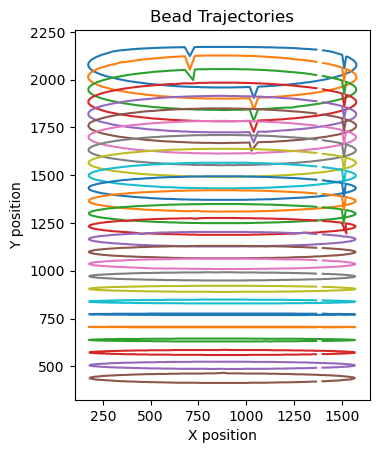

In [241]:
# Plot the trajectories of the beads
fig, ax = plt.subplots()
for ID in trajectories:
    if trajectories[ID][1] is not None:
        ax.plot(trajectories[ID][0][:, 0], trajectories[ID][0][:, 1], label=f"Bead {ID}")
ax.set_aspect('equal', 'box')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title('Bead Trajectories')
# plt.legend()
plt.show()


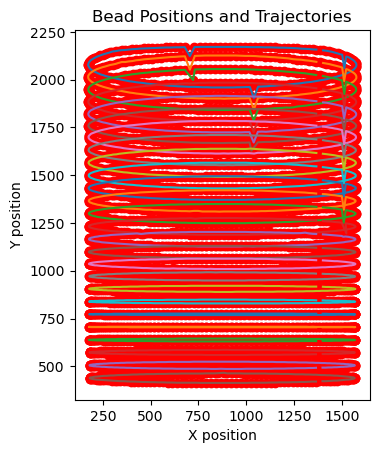

In [242]:
# Plot the bead positions and trajectories
fig, ax = plt.subplots()
for i in range(dilated_img.shape[0]):
    if len(bead_positions_all[i]) > 0:
        ax.scatter(bead_positions_all[i][:, 1], bead_positions_all[i][:, 0], color='red')
for ID in trajectories:
    if trajectories[ID][1] is not None:
        ax.plot(trajectories[ID][0][:, 0], trajectories[ID][0][:, 1], label=f"Bead {ID}")
ax.set_aspect('equal', 'box')
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title('Bead Positions and Trajectories')
# plt.legend()
plt.show()


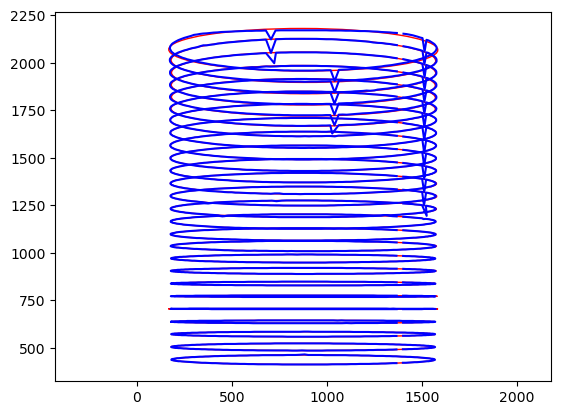

In [243]:
for ID in trajectories:
    if trajectories[ID][1] is not None:
        # Plot the trajectory and ellipse
        trajectory = trajectories[ID][0]
        ellipse = trajectories[ID][1]
        plt.plot(trajectory[:, 0], trajectory[:, 1], 'b')
        ellipse_patch = Ellipse(xy=ellipse[0], width=ellipse[1][0], height=ellipse[1][1], angle=ellipse[2], edgecolor='r', facecolor='none')
        plt.gca().add_patch(ellipse_patch)
plt.axis('equal')
plt.show()


## removes ellipses with outlier major axis and orientation values:

In [246]:
len(trajectories)

26

In [247]:
# Calculate the major axis lengths of the ellipses
major_axis_lengths = [ellipse[1][1] for ID, (trajectory, ellipse) in trajectories.items() if ellipse is not None]

# Calculate the median major axis length
median_major_axis_length = np.median(major_axis_lengths)

# Define a threshold for major axis length as 2 times the median
major_axis_length_threshold = 1.5 * median_major_axis_length

# Remove outlier ellipses with major axis length greater than the threshold
for ID, (trajectory, ellipse) in list(trajectories.items()):
    if ellipse is not None and ellipse[1][1] > major_axis_length_threshold:
        trajectories.pop(ID)

In [248]:
len(trajectories)

26

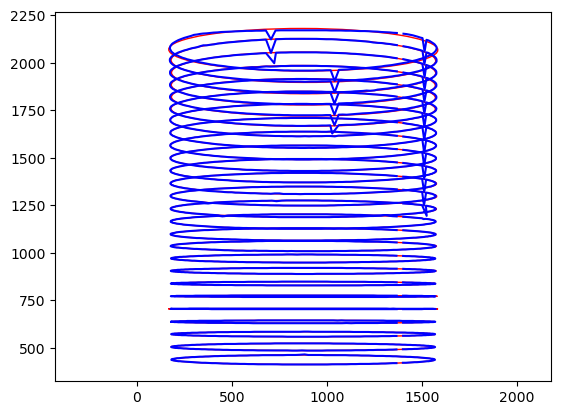

In [249]:
for ID in trajectories:
    if trajectories[ID][1] is not None:
        # Plot the trajectory and ellipse
        trajectory = trajectories[ID][0]
        ellipse = trajectories[ID][1]
        plt.plot(trajectory[:, 0], trajectory[:, 1], 'b')
        ellipse_patch = Ellipse(xy=ellipse[0], width=ellipse[1][0], height=ellipse[1][1], angle=ellipse[2], edgecolor='r', facecolor='none')
        plt.gca().add_patch(ellipse_patch)
plt.axis('equal')
plt.show()


1.0
179
2.0
179
3.0
179
4.0
179
5.0
179
6.0
179
7.0
179
8.0
179
9.0
179
10.0
179
11.0
179
12.0
179
13.0
179
14.0
179
15.0
179
16.0
179
17.0
179
18.0
179
19.0
179
20.0
179
21.0
179
22.0
179
23.0
179
24.0
179
25.0
179
26.0
179


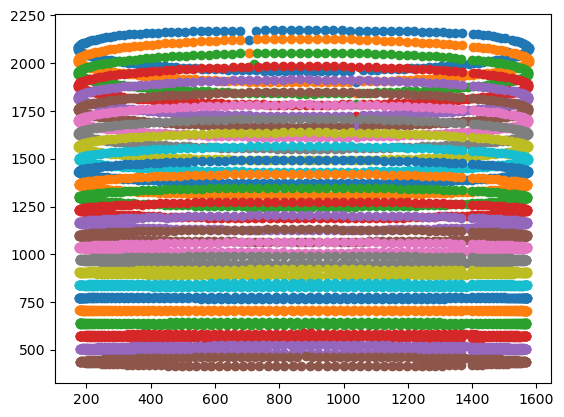

In [250]:
for ID in trajectories:
    if trajectories[ID][1] is not None:
        print(ID)
        print(len(trajectories[ID][0]))
        plt.scatter(trajectories[ID][0][:, 0], trajectories[ID][0][:, 1])

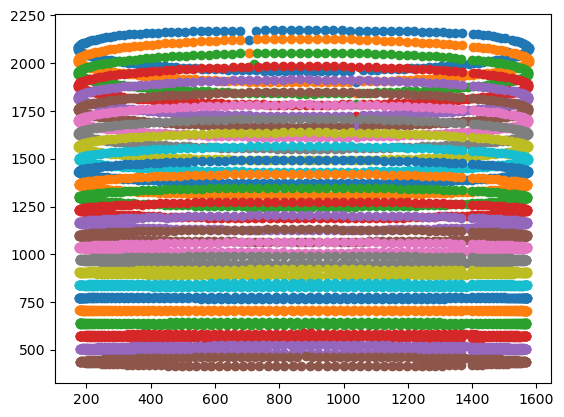

In [251]:
trajectories_x = []
trajectories_y = []

for ID in trajectories:
    if trajectories[ID][1] is not None:
        trajectories_x.append(np.ravel(trajectories[ID][0][:, 0]).tolist())
        trajectories_y.append(np.ravel(trajectories[ID][0][:, 1]).tolist())
    
        plt.scatter(np.ravel(trajectories[ID][0][:, 0]), np.ravel(trajectories[ID][0][:, 1]))

trajectories_x = np.array(trajectories_x)
trajectories_y = np.array(trajectories_y)

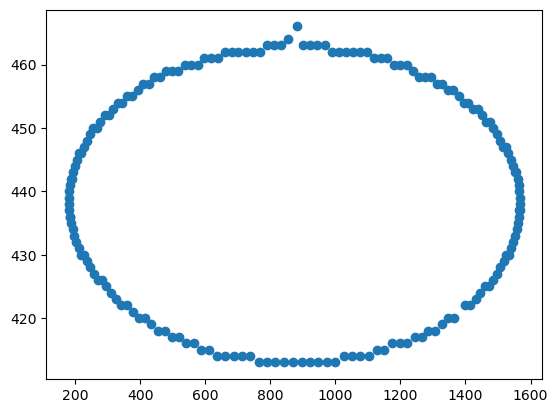

In [252]:
ID== 20
plt.scatter(trajectories[ID][0][:, 0], trajectories[ID][0][:, 1])

In [253]:
ID

26.0

In [254]:
type(trajectories[ID][0][:, 0])

numpy.ndarray

In [255]:
trajectories[ID][0][:, 0].dtype

dtype('float32')

In [256]:
trajectories[ID][0][:, 0]

array([1365., 1346., 1327., 1307., 1286., 1265., 1244., 1221., 1198.,
       1174., 1151., 1127., 1102., 1077., 1052., 1026., 1000.,  974.,
        948.,  922.,  896.,  869.,  843.,  816.,  790.,  764.,  738.,
        712.,  687.,  662.,  637.,  612.,  588.,  565.,  542.,  519.,
        497.,  475.,  454.,  433.,  414.,  395.,  377.,  359.,  342.,
        326.,  311.,  296.,  283.,  270.,  258.,  247.,  236.,  227.,
        218.,  211.,  204.,  198.,  193.,  189.,  185.,  183.,  181.,
        181.,  181.,  182.,  184.,  186.,  190.,  194.,  199.,  205.,
        212.,  219.,  227.,  236.,  246.,  256.,  267.,  278.,  291.,
        303.,  317.,  331.,  345.,  360.,  376.,  392.,  409.,  426.,
        443.,  461.,  479.,  498.,  517.,  537.,  557.,  577.,  597.,
        618.,  639.,  660.,  681.,  702.,  724.,  746.,  768.,  790.,
        812.,  834.,  854.,  882.,  901.,  923.,  945.,  967.,  989.,
       1011., 1033., 1054., 1076., 1097., 1118., 1139., 1159., 1180.,
       1199., 1219.,

In [257]:
trajectories[ID][0][:, 1]

array([420., 420., 419., 418., 418., 417., 417., 416., 416., 416., 415.,
       415., 414., 414., 414., 414., 413., 413., 413., 413., 413., 413.,
       413., 413., 413., 413., 414., 414., 414., 414., 414., 415., 415.,
       416., 416., 417., 417., 418., 418., 419., 420., 420., 421., 422.,
       422., 423., 424., 425., 426., 426., 427., 428., 429., 430., 430.,
       431., 432., 433., 434., 435., 436., 436., 437., 438., 439., 440.,
       441., 442., 442., 443., 444., 445., 446., 446., 447., 448., 449.,
       450., 450., 451., 452., 452., 453., 454., 454., 455., 455., 456.,
       457., 457., 458., 458., 459., 459., 459., 460., 460., 460., 461.,
       461., 461., 462., 462., 462., 462., 462., 462., 463., 463., 463.,
       464., 466., 463., 463., 463., 463., 462., 462., 462., 462., 462.,
       462., 461., 461., 461., 460., 460., 460., 459., 458., 458., 458.,
       457., 457., 456., 456., 455., 454., 454., 453., 453., 452., 451.,
       451., 450., 449., 448., 447., 447., 446., 44

In [258]:
# trajectories

In [259]:
trajectory.shape

(179, 2)

In [260]:
# trajectories

In [470]:

trajectories_x = []
trajectories_y = []

for ID in trajectories:
    if trajectories[ID][1] is not None:
        trajectories_x.append(np.ravel(trajectories[ID][0][:, 0]).tolist())
        trajectories_y.append(np.ravel(trajectories[ID][0][:, 1]).tolist())

trajectories_x = np.array(trajectories_x)
trajectories_y = np.array(trajectories_y)


In [471]:
trajectories_x[0]

array([1569., 1578., 1586., 1593., 1600., 1606., 1612., 1616., 1620.,
       1623., 1625., 1627., 1627., 1627., 1626., 1624., 1621., 1618.,
       1613., 1608., 1601., 1594., 1586., 1578., 1568., 1558., 1546.,
       1535., 1522., 1508., 1493., 1479., 1463., 1446., 1428., 1410.,
       1392., 1372., 1352., 1331., 1310., 1288., 1268., 1242., 1220.,
       1197., 1172., 1149., 1124., 1100., 1074., 1049., 1023.,  998.,
        972.,  946.,  921.,  895.,  870.,  845.,  820.,  794.,  770.,
        745.,  721.,  698.,  674.,  651.,  629.,  607.,  585.,  564.,
        544.,  524.,  505.,  487.,  469.,  452.,  436.,  420.,  405.,
        391.,  378.,  366.,  354.,  343.,  333.,  324.,  316.,  308.,
        302.,  296.,  291.,  287.,  284.,  281.,  280.,  279.,  279.,
        280.,  282.,  285.,  288.,  292.,  297.,  303.,  309.,  316.,
        324.,  333.,  342.,  352.,  362.,  373.,  385.,  398.,  411.,
        424.,  439.,  453.,  468.,  484.,  500.,  517.,  534.,  551.,
        569.,  587.,

In [472]:
trajectories_y[0]

array([2003., 2006., 2010., 2013., 2017., 2021., 2025., 2028., 2032.,
       2036., 2040., 2044., 2048., 2052., 2056., 2059., 2063., 2067.,
       2071., 2075., 2079., 2083., 2086., 2090., 2094., 2097., 2101.,
       2105., 2108., 2112., 2115., 2118., 2121., 2124., 2128., 2130.,
       2133., 2135., 2138., 2140., 2143., 2146., 2151., 2151., 2150.,
       2151., 2152., 2153., 2153., 2089., 2154., 2155., 2155., 2155.,
       2155., 2155., 2155., 2155., 2155., 2155., 2154., 2153., 2153.,
       2152., 2151., 2150., 2149., 2148., 2146., 2144., 2141., 2139.,
       2136., 2134., 2131., 2128., 2125., 2122., 2119., 2116., 2112.,
       2109., 2105., 2102., 2099., 2096., 2092., 2087., 2083., 2079.,
       2076., 2072., 2068., 2064., 2060., 2056., 2052., 2049., 2045.,
       2041., 2037., 2033., 2029., 2025., 2022., 2018., 2014., 2011.,
       2007., 2003., 2000., 1997., 1994., 1990., 1987., 1984., 1981.,
       1978., 1975., 1972., 1970., 1967., 1964., 1962., 1960., 1958.,
       1956., 1954.,

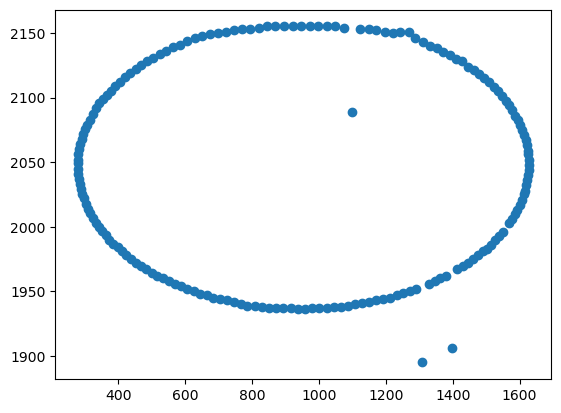

In [473]:
plt.scatter(trajectories_x[0],trajectories_y[0])

In [474]:
trajectories_x.shape

(26, 179)

In [475]:
# trajectories_x

In [476]:
np.array(bead_ids_all[0]).reshape(-1, 1).shape

(29, 1)

In [477]:
np.array(bead_positions_all[0]).shape

(26, 2)

In [478]:
# bead_positions_all.shape

In [479]:
# # Find the minimum number of beads in all the projections
# min_beads = np.min([len(bead_positions_all[i]) for i in range(dilated_img.shape[0])])

# # Remove extra beads from each projection
# for i in range(dilated_img.shape[0]):
#     if len(bead_positions_all[i]) > min_beads:
#         num_extra_beads = len(bead_positions_all[i]) - min_beads
#         bead_positions_all[i] = bead_positions_all[i][num_extra_beads:]

# # Convert the remaining bead positions to NumPy arrays
# bead_positions_all = [np.array(bead_positions) for bead_positions in bead_positions_all]


# # # Plot the remaining bead positions only for projections 1, 10, 20, and 30
# # fig, ax = plt.subplots()
# # for i in [0, 1, 2, 3]:
# #     if len(bead_positions_all[i]) > 0:
# #         ax.scatter(bead_positions_all[i][:,1], bead_positions_all[i][:,0], color='red', label=f"Projection {i+1}")
# # ax.set_aspect('equal', 'box')
# # ax.set_xlabel('X position')
# # ax.set_ylabel('Y position')
# # ax.set_title('Remaining Bead Positions')
# # plt.legend()
# # plt.show()



# # Plot the remaining bead positions for all projections
# fig, ax = plt.subplots()
# for i in range(dilated_img.shape[0]):
#     if len(bead_positions_all[i]) > 0:
#         ax.scatter(bead_positions_all[i][:,1], bead_positions_all[i][:,0], color='red')
# ax.set_aspect('equal', 'box')
# ax.set_xlabel('X position')
# ax.set_ylabel('Y position')
# ax.set_title('Remaining Bead Positions')
# plt.legend()
# plt.show()


In [480]:
# min_beads

In [481]:
# bead_positions_all = np.array(bead_positions_all)
# bead_positions_all.shape

In [482]:
# # Convert bead_positions_all to a NumPy array
# bead_positions_all = np.array(bead_positions_all)

# # Get the number of beads
# num_beads = bead_positions_all.shape[1]

# # Collect the corresponding bead positions for each row across all projections
# bead_positions_row = []
# for i in range(num_beads):
#     bead_positions_row.append(bead_positions_all[:, i, :])

# # Plot the selected bead positions for each row
# fig, ax = plt.subplots()
# for i, positions in enumerate(bead_positions_row):
#     positions = np.array(positions)
#     if positions.size != 0:
#         ax.scatter(positions[:,1], positions[:,0], label=f"Bead Row {i+1}")
# ax.set_aspect('equal', 'box')
# ax.set_xlabel('X position')
# ax.set_ylabel('Y position')
# ax.set_title('Selected Bead Positions by Row')
# # plt.legend()
# plt.show()


In [483]:
# ellipses = np.array(bead_positions_row)
# bead_positions_row = np.array(bead_positions_row)
# ellipses.shape

In [484]:
# # Remove outliers from each row in bead_positions_row
# # Compute the median and standard deviation of each row
# row_medians = np.nanmedian(bead_positions_row, axis=1)
# row_stdevs = np.nanstd(bead_positions_row, axis=1)

# mask = np.abs(bead_positions_row - row_medians[:, np.newaxis]) < 1.4 * row_stdevs[:, np.newaxis]
# bead_positions_row = np.where(mask, bead_positions_row, np.nan)

# # Plot the remaining bead positions
# fig, ax = plt.subplots()
# for i, row in enumerate(bead_positions_row):
#     valid = ~np.isnan(row[:, 1])  # Find indices of valid (non-NaN) bead positions
#     ax.scatter(row[valid, 1], row[valid, 0], label=f"Row {i+1}")
# ax.set_aspect('equal', 'box')
# ax.set_xlabel('X position')
# ax.set_ylabel('Y position')
# ax.set_title('Selected Bead Positions without Outliers')
# # plt.legend()
# plt.show()


In [485]:
# bead_positions_row.shape

In [486]:
# ellipses = bead_positions_row

# for elli in range(len(ellipses[:,:,:])):
#     x= ellipses[elli,:,0]
#     y= ellipses[elli,:,1]
#     plt.scatter(x,y, s=20, marker='o',cmap = 'RdYlBu_r')

In [487]:
# y= ellipses[10,:,0] # The first 10 are crap!!
# x= ellipses[10,:,1]
# plt.scatter(x,y, s=20, marker='o',cmap = 'RdYlBu_r')

In [488]:
# row = bead_positions_row[0]
# mask = np.logical_or(np.isnan(row), np.isinf(row))
# print(np.any(mask))


In [489]:
# # Remove NaN and inf values from bead_positions_row
# bead_positions_row[np.logical_not(np.isfinite(bead_positions_row))] = 0



In [490]:
# import numpy as np

# # assume bead_positions_row is a 2D array with shape (n_projections, n_beads, 2)
# # loop through each row of bead_positions_row
# for i in range(bead_positions_row.shape[0]):
#     # loop through each column (bead) of the current row
#     for j in range(bead_positions_row.shape[1]):
#         # check if the x or y coordinate is NaN
#         if np.isnan(bead_positions_row[i, j, 0]) or np.isnan(bead_positions_row[i, j, 1]):
#             # find the indices of the previous and next valid values along the current row
#             prev_index = j - np.isnan(bead_positions_row[i, :j, 0])[::-1].argmax() - 1
#             next_index = j + np.isnan(bead_positions_row[i, j:, 0]).argmin()
#             # interpolate the missing value using the previous and next valid values
#             bead_positions_row[i, j, 0] = np.interp(j, [prev_index, next_index], [bead_positions_row[i, prev_index, 0], bead_positions_row[i, next_index, 0]])
#             bead_positions_row[i, j, 1] = np.interp(j, [prev_index, next_index], [bead_positions_row[i, prev_index, 1], bead_positions_row[i, next_index, 1]])


In [491]:
# row = bead_positions_row[0]
# mask = np.logical_or(np.isnan(row), np.isinf(row))
# print(np.any(mask))

In [261]:
# fitting an ellipse 
# based on Fitzgibbon, Pilu, & Fisher (1996) and Halir & Flusser (1998)
def fit(x,y):
    D1 = np.vstack([x**2,x*y,y**2]).T
    D2 = np.vstack([x,y,np.ones_like(x)]).T
    S1,S2,S3 = D1.T @ D1, D1.T @ D2, D2.T @ D2
    C1 = np.array([[0,0,2],[0,-1,0],[2,0,0]])
    M = np.linalg.inv(C1) @ (S1 - S2 @ np.linalg.inv(S3) @ S2.T)
    vec = np.linalg.eig(M)[1]
    cond = 4*(vec[0]*vec[2]) - vec[1]**2
    a1 = vec[:,np.nonzero(cond > 0)[0]]
    return np.vstack([a1,np.linalg.inv(-S3) @ S2.T @ a1]).flatten()

In [262]:
# estimating the errors using chi-squared
from uncertainties import ufloat

def errors(x,y,coeffs):
    z = np.vstack((x**2,x*y,y**2,x,y,np.ones_like(x)))
    numerator = np.sum(((coeffs.reshape(1,6) @ z)-1)**2)
    denominator = (len(x)-6)*np.sum(z**2,axis=1)
    unc = np.sqrt(numerator/denominator)
    return tuple(ufloat(i,j) for i,j in zip(coeffs,unc))

In [263]:
# def errors(x,y,coeffs):
#     if coeffs.ndim != 1:
#         raise ValueError("Coefficients must be a 1D array")
#     z = np.vstack((x**2,x*y,y**2,x,y,np.ones_like(x))).T
#     numerator = np.sum(((coeffs.reshape(-1, 1) @ z.T)-1)**2)

#     denominator = (len(x)-6)*np.sum(z**2,axis=1)
#     unc = np.sqrt(numerator/denominator)
#     return tuple(ufloat(i,j) for i,j in zip(coeffs,unc))


In [264]:
# converting the coefficients to ellipse parameters
import uncertainties
from uncertainties import umath
def convert(coeffs):
    a,b,c,d,e,f = coeffs
    b /= 2
    d /= 2
    e /= 2
    x0 = (c*d - b*e) / (b**2 - a*c)
    y0 = (a*e - b*d) / (b**2 - a*c)
    center = (x0, y0)
    numerator = 2 * (a*e**2 + c*d**2 + f*b**2 - 2*b*d*e - a*c*f)
    denominator1 = (b*b-a*c)*((c-a)*umath.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    denominator2 = (b*b-a*c)*((a-c)*umath.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    major = umath.sqrt(numerator/denominator1) if numerator/denominator1 > 0 else 0
    minor = umath.sqrt(numerator/denominator2) if numerator/denominator2 > 0 else 0
    phi = .5*umath.atan((2*b)/(a-c))
    major, minor, phi = (major, minor, phi) if major > minor else (minor, major, np.pi/2+phi)
    return center, major, minor, phi

In [265]:
# generating fit ellipse line
def line(coeffs,n=100):
    t = np.linspace(0,2*np.pi,n)
    center,major,minor,phi = convert(coeffs)
    x = major*np.cos(t)*np.cos(phi) - minor*np.sin(t)*np.sin(phi) + center[0]
    y = major*np.cos(t)*np.sin(phi) + minor*np.sin(t)*np.cos(phi) + center[1]
    return x,y

# alternative using matplotlib artists
def artist(coeffs,*args,**kwargs):
    center,major,minor,phi = convert(coeffs)
    return Ellipse(xy=(center[0],center[1]),width=2*major,height=2*minor,
                     angle=np.rad2deg(phi),*args,**kwargs)

In [266]:
# obtaining the confidence interval/area for ellipse fit
def confidence_area(x,y,coeffs,f=1): # f here is the multiple of sigma
    c = coeffs
    res = c[0]*x**2 + c[1]*x*y + c[2]*y**2 + c[3]*x + c[4]*y + c[5]
    sigma = np.std(res)
#     print('Sigma = ', sigma)
    c_up = np.array([c[0],c[1],c[2],c[3],c[4],c[5] + f*sigma])
    c_do = np.array([c[0],c[1],c[2],c[3],c[4],c[5] - f*sigma])
   
    if convert(c_do) > convert(c_up):
        c_do, c_up = c_up,c_do
    return c_up,c_do

In [267]:
len(trajectories)

26

In [268]:
for ID in trajectories:
    sigma_ell =[]
    
    x= trajectories[ID][0][:, 1]
    y= trajectories[ID][0][:, 0]
print(x)
print(y)

[420. 420. 419. 418. 418. 417. 417. 416. 416. 416. 415. 415. 414. 414.
 414. 414. 413. 413. 413. 413. 413. 413. 413. 413. 413. 413. 414. 414.
 414. 414. 414. 415. 415. 416. 416. 417. 417. 418. 418. 419. 420. 420.
 421. 422. 422. 423. 424. 425. 426. 426. 427. 428. 429. 430. 430. 431.
 432. 433. 434. 435. 436. 436. 437. 438. 439. 440. 441. 442. 442. 443.
 444. 445. 446. 446. 447. 448. 449. 450. 450. 451. 452. 452. 453. 454.
 454. 455. 455. 456. 457. 457. 458. 458. 459. 459. 459. 460. 460. 460.
 461. 461. 461. 462. 462. 462. 462. 462. 462. 463. 463. 463. 464. 466.
 463. 463. 463. 463. 462. 462. 462. 462. 462. 462. 461. 461. 461. 460.
 460. 460. 459. 458. 458. 458. 457. 457. 456. 456. 455. 454. 454. 453.
 453. 452. 451. 451. 450. 449. 448. 447. 447. 446. 445. 444. 443. 443.
 442. 441. 440. 439. 438. 437. 437. 436. 435. 434. 433. 432. 431. 430.
 430. 429. 428. 427. 426. 425. 425. 424. 423. 422. 422.]
[1365. 1346. 1327. 1307. 1286. 1265. 1244. 1221. 1198. 1174. 1151. 1127.
 1102. 1077. 1052.

In [269]:
# trajectories

In [270]:
# trajectories

In [271]:
# import matplotlib.patches as patches

# trajectories_x = []
# trajectories_y = []

# for ID in trajectories:
#     if trajectories[ID][1] is not None:
#         trajectories_x.append(np.ravel(trajectories[ID][0][:, 0]).tolist())
#         trajectories_y.append(np.ravel(trajectories[ID][0][:, 1]).tolist())

# trajectories_x = np.array(trajectories_x)
# trajectories_y = np.array(trajectories_y)


# # numebr of itterations for outlier removal
# N = 1

# ell_all = []
# err_all = []
# Sigma_all = [] 
# M = len(trajectories)-10
# print('M = ', M)
        
# for iii in range(M):
    
#     print('ID = ', iii)

#     sigma_ell =[]

#     x= trajectories_x[iii]
#     y= trajectories_y[iii]

#     for ell_ii in range(N):
#         # do fitting
#         params1 = fit(x,y)
#         params1 = errors(x,y,params1)

#         center, a, b, phi = convert(params1)
#         c_up, c_do = confidence_area(x,y,[i.n for i in params1],f=2) 
#         if convert(c_do) > convert(c_up):
#             c_do, c_up = c_up,c_do

#         # do the outlier removal
#         mask1 = artist(c_up,ec='none') 
#         mask2 = artist(c_do,ec='none') 

#                 # The ellipse1
#         g_ell_center = getattr(mask1, "center")
#         g_ell_width = getattr(mask1, "width")
#         g_ell_height = getattr(mask1, "height")
#         angle = getattr(mask1, "angle")

#         g_ellipse = patches.Ellipse(g_ell_center, g_ell_width, g_ell_height, angle=angle, fill=False, edgecolor='skyblue', linewidth=2)
#         ax.add_patch(g_ellipse)

#         cos_angle = np.cos(np.radians(180.-angle))
#         sin_angle = np.sin(np.radians(180.-angle))

#         xc = x - g_ell_center[0]
#         yc = y - g_ell_center[1]

#         xct = xc * cos_angle - yc * sin_angle
#         yct = xc * sin_angle + yc * cos_angle 

#         rad_cc = (xct**2/(g_ell_width/2.)**2) + (yct**2/(g_ell_height/2.)**2)

#                 # The ellipse2
#         g_ell_center2 = getattr(mask2, "center")
#         g_ell_width2 = getattr(mask2, "width")
#         g_ell_height2 = getattr(mask2, "height")
#         angle2 = getattr(mask2, "angle")

#         g_ellipse2 = patches.Ellipse(g_ell_center2, g_ell_width2, g_ell_height2, angle=angle2, fill=False, edgecolor='skyblue', linewidth=2)
#         ax.add_patch(g_ellipse2)

#         cos_angle2 = np.cos(np.radians(180.-angle2))
#         sin_angle2 = np.sin(np.radians(180.-angle2))

#         xc2 = x - g_ell_center2[0]
#         yc2 = y - g_ell_center2[1]

#         xct2 = xc2 * cos_angle2 - yc2 * sin_angle2
#         yct2 = xc2 * sin_angle2 + yc2 * cos_angle2 

#         rad_cc2 = (xct2**2/(g_ell_width2/2.)**2 ) + (yct2**2/(g_ell_height2/2.)**2)

#         # define new X and Y as modified
#         xy_array = np.array([x,y])
#         modified_array1 = np.delete(xy_array, np.where(rad_cc2 <= 1.)[0], 1)
#         modified_array2 = np.delete(modified_array1, np.where(rad_cc >= 1.)[0], 1)
#         x = modified_array2[0]
#         y = modified_array2[1]

#         sigma =  abs(((c_up-c_do)/2)[5])
#         sigma_ell.append(sigma)

#     ell = convert(params1)
#     ell_all.append(ell)


#     # plot of fit and confidence area
#     fig,ax = plt.subplots()
#     ax.plot(x,y,'sr',label='Data')
#     ax.plot(*line([i.n for i in params1]),'--b',lw=1,label='Fit')
#     ax.add_patch(artist(c_up,ec='none',fc='r',alpha=0.15,label=r'2$\sigma$'))
#     ax.add_patch(artist(c_do,ec='none',fc='white'))
#     ax.legend()
#     ax.set_xlabel('x')
#     ax.set_ylabel('y')
#     fig2,ax2 = plt.subplots()
#     ax2.plot(sigma_ell)
#     plt.title('sigma decay')

#     print('last sigma value = ', sigma_ell[-1])
#     plt.show()

M =  26
ID =  0
last sigma value =  2894.8258254984394


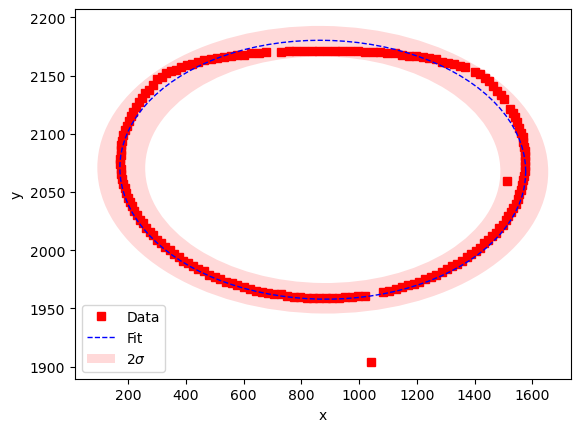

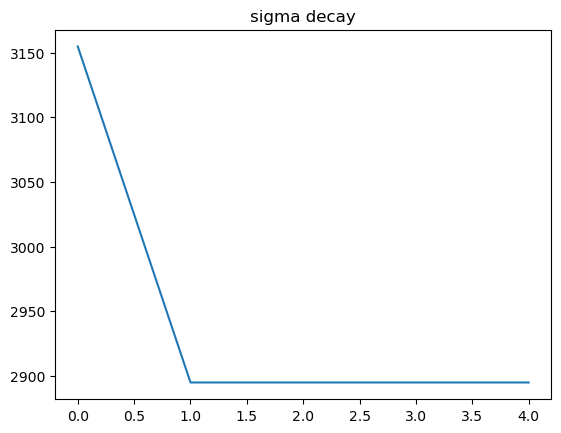

ID =  1
last sigma value =  2486.104109614156


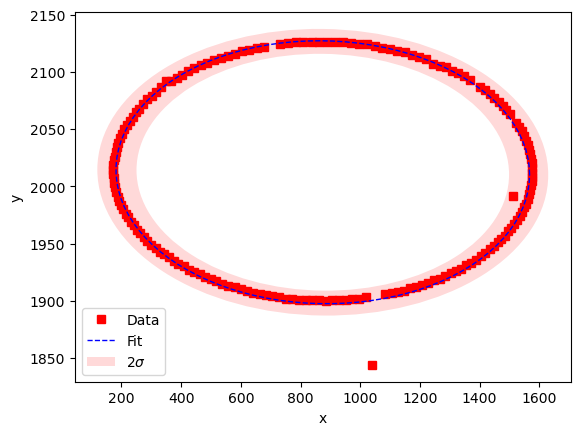

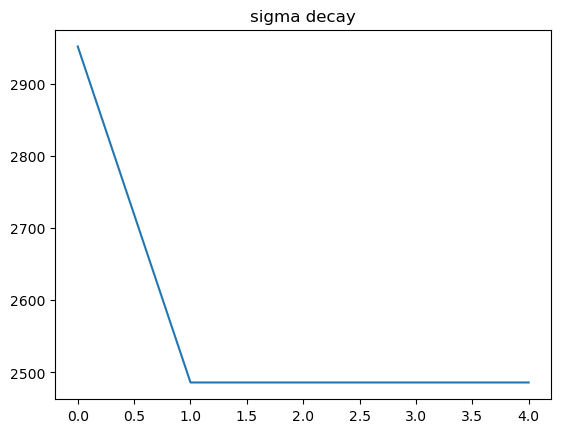

ID =  2
last sigma value =  2355.819694100879


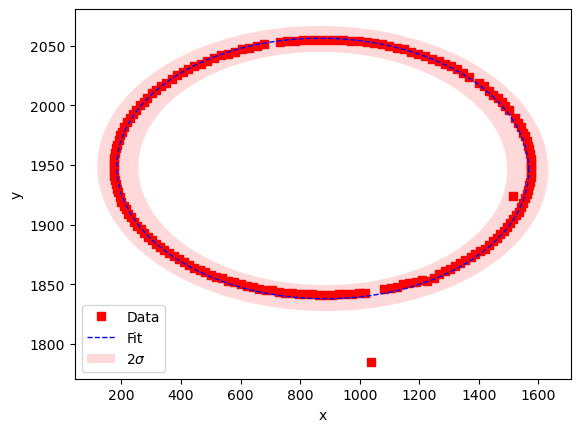

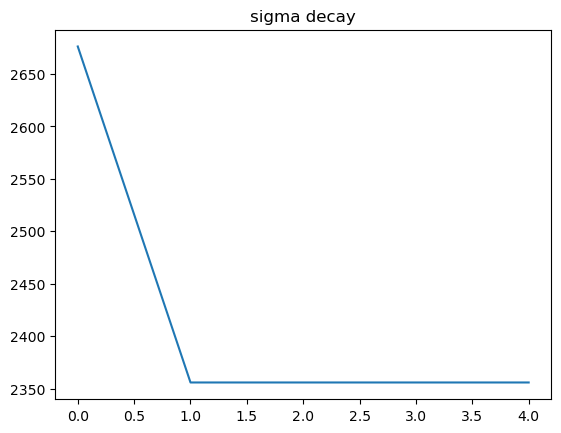

ID =  3
last sigma value =  2226.1885171867907


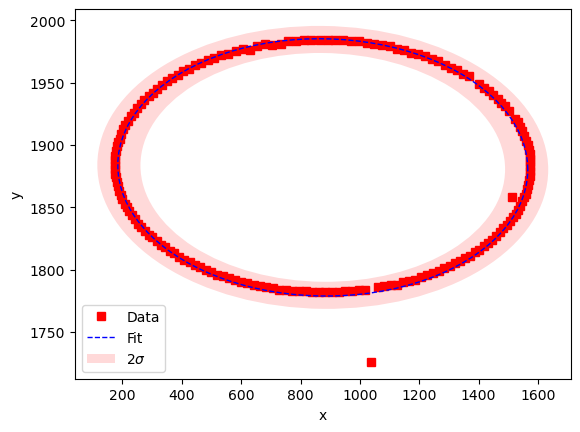

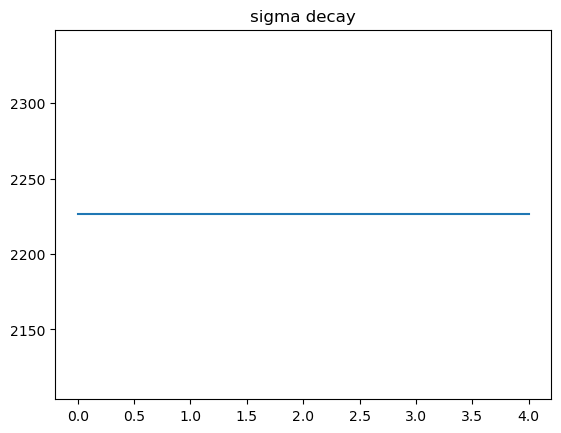

ID =  4
last sigma value =  1975.8109179600142


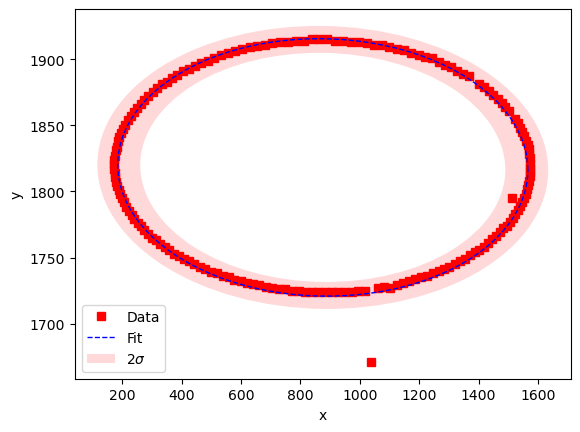

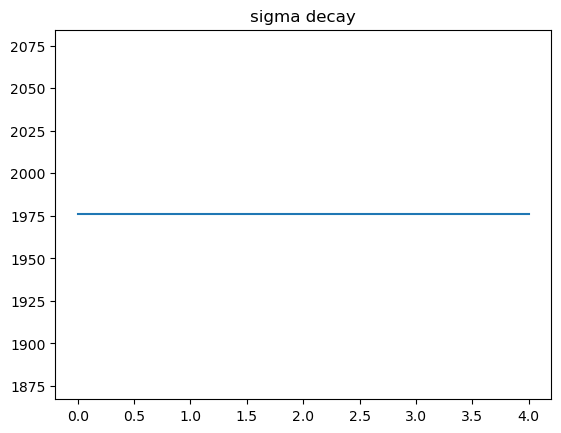

ID =  5
last sigma value =  1380.386040251702


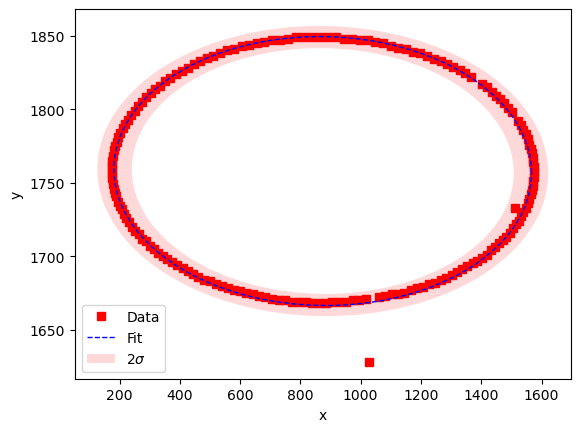

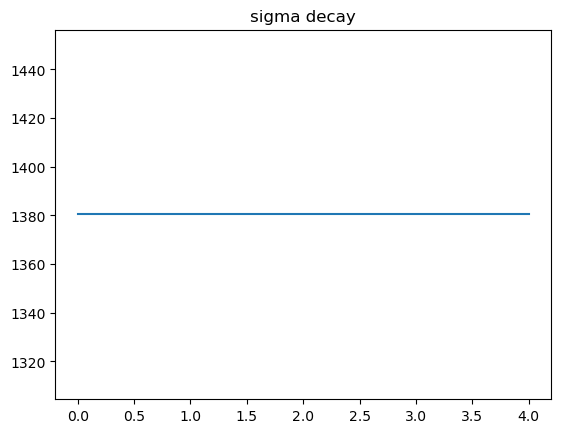

ID =  6
last sigma value =  103.39120289869606


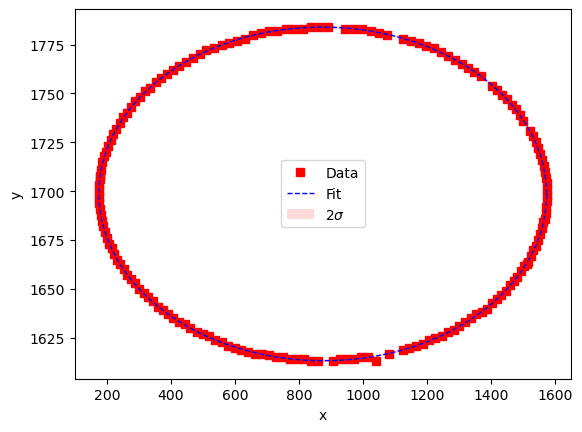

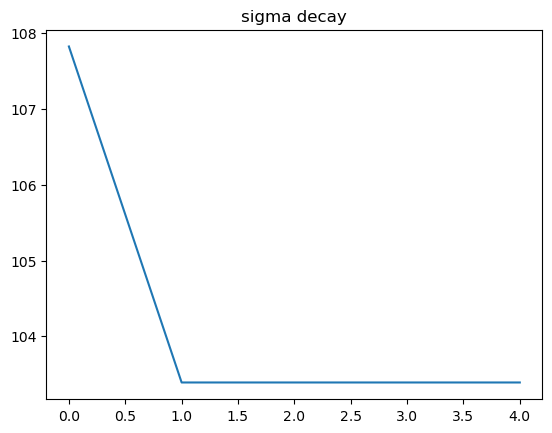

ID =  7
last sigma value =  76.37529560178518


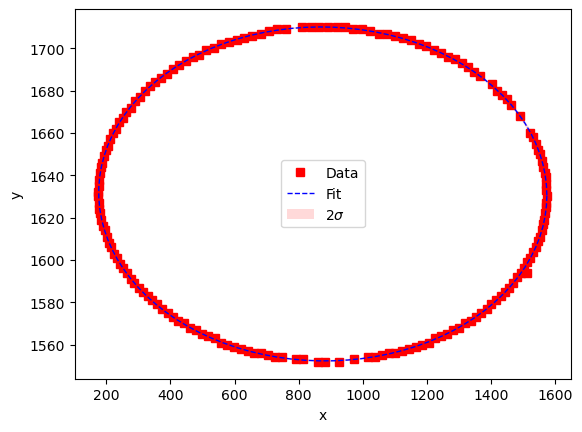

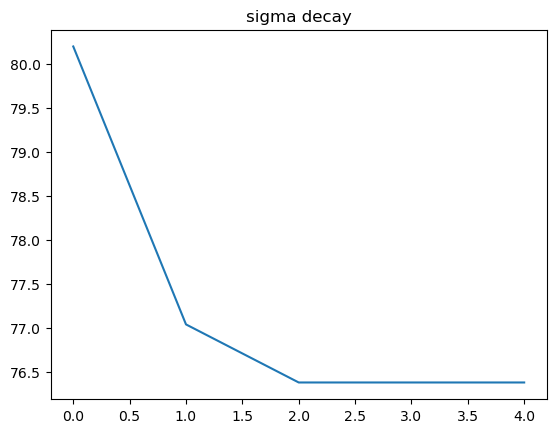

ID =  8
last sigma value =  131.05208275699988


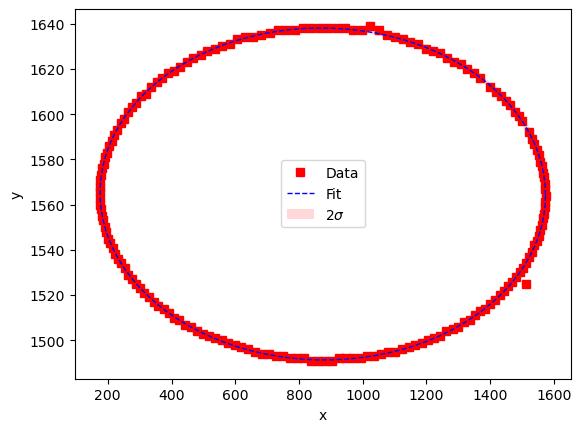

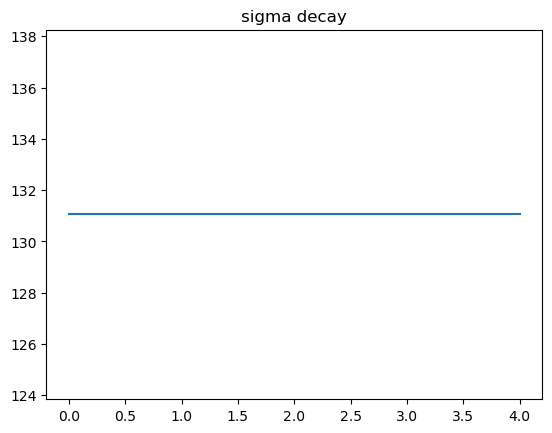

ID =  9
last sigma value =  145.4094153563492


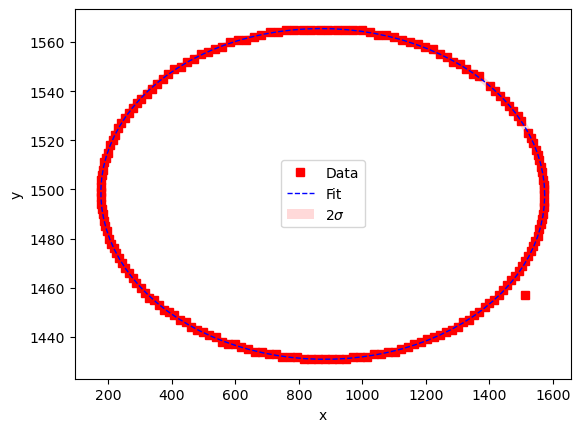

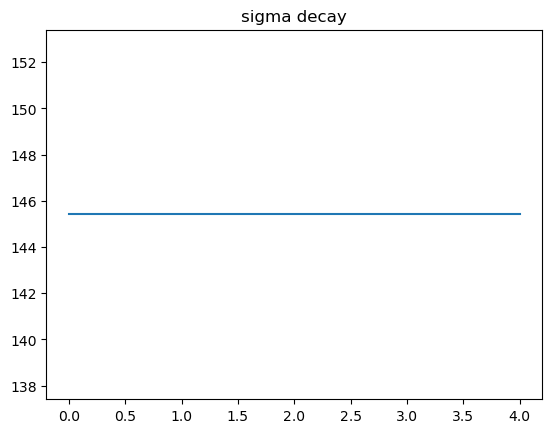

ID =  10
last sigma value =  197.4711109593045


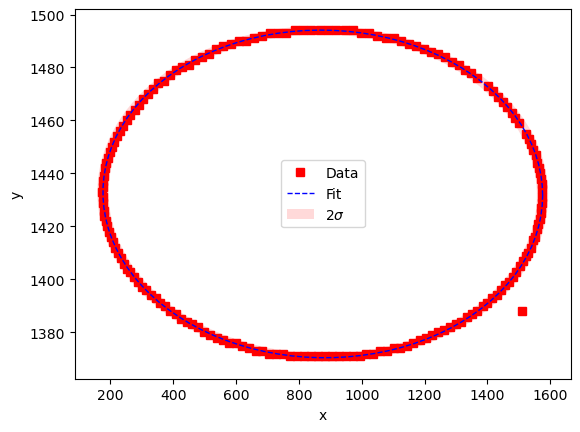

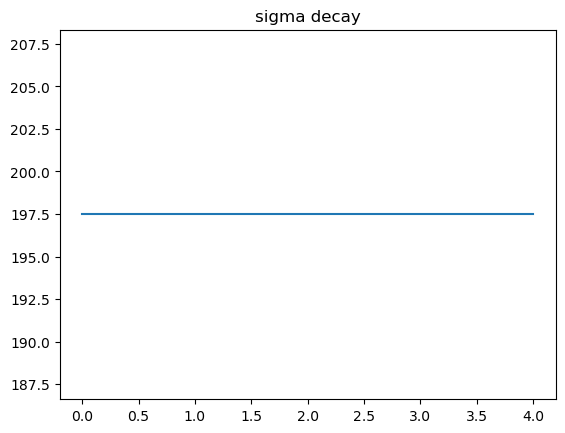

ID =  11
last sigma value =  238.8548584585078


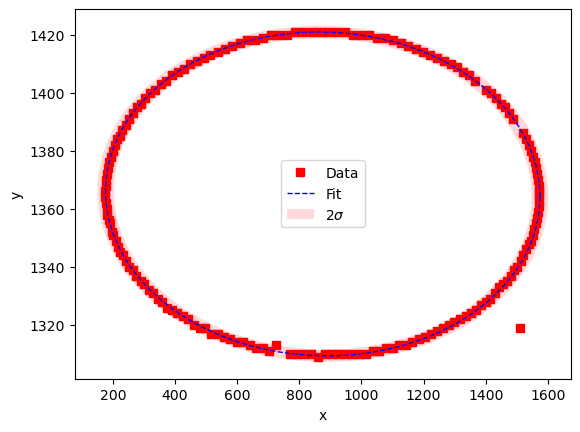

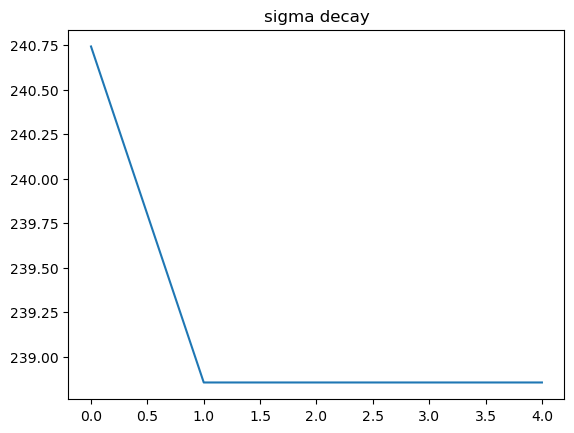

ID =  12
last sigma value =  285.06500586587936


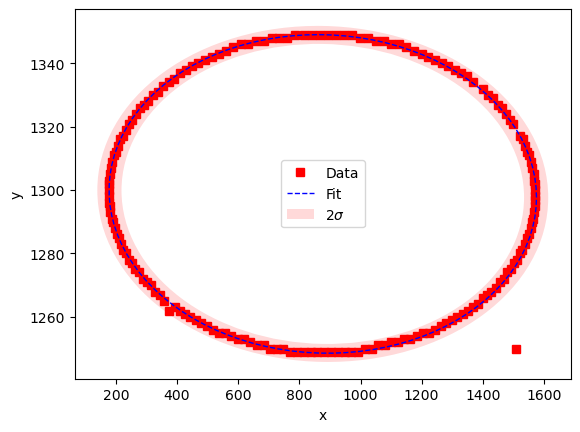

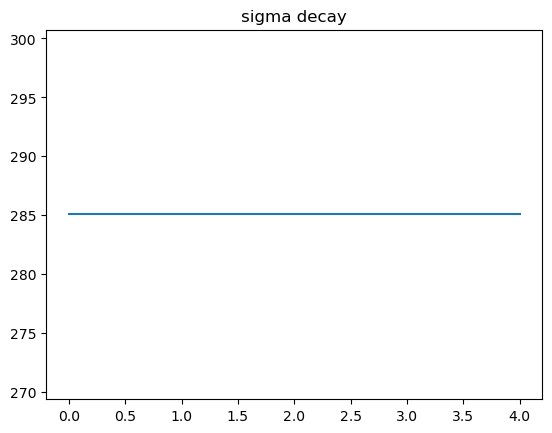

ID =  13
last sigma value =  169.21795338089578


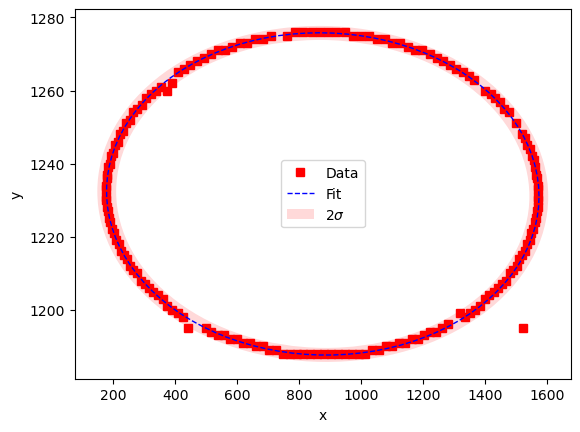

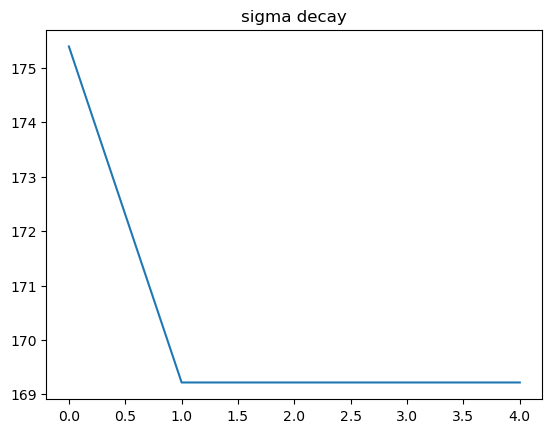

ID =  14
last sigma value =  28.268976241583005


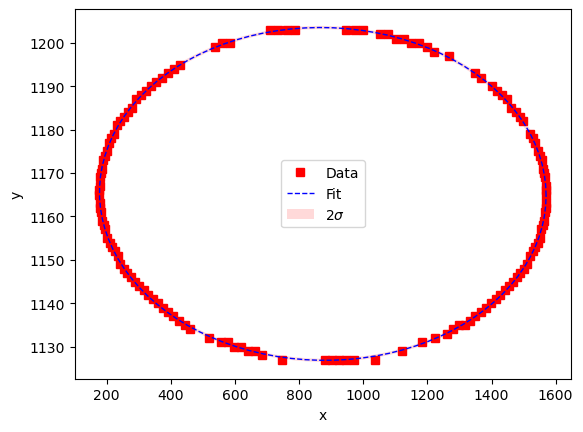

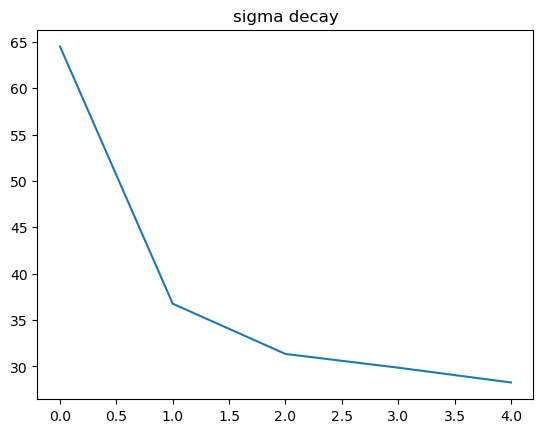

ID =  15
last sigma value =  21.840363340452313


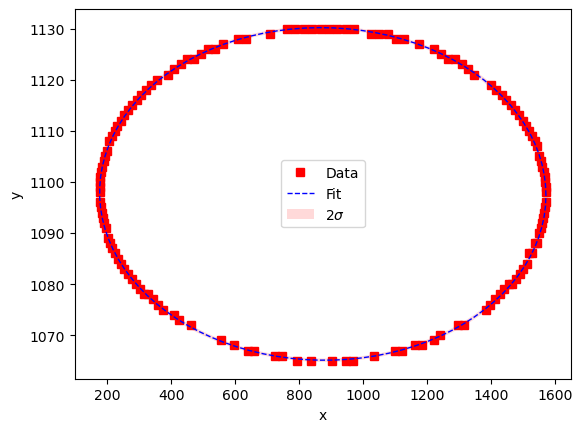

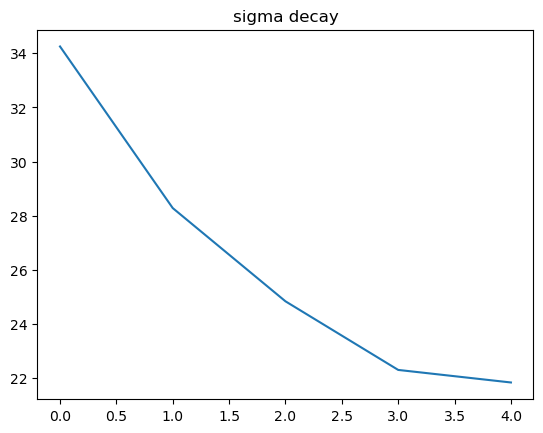

ID =  16
last sigma value =  20.938875266350806


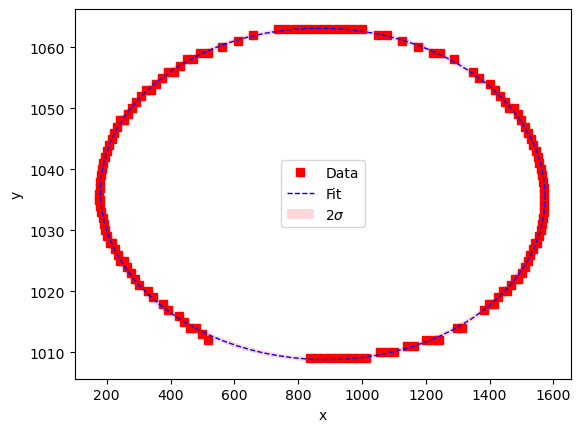

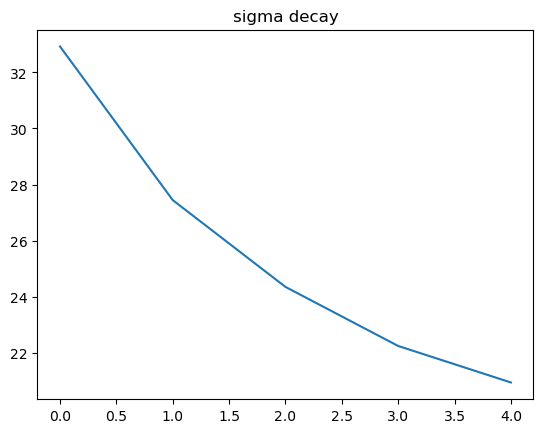

ID =  17
last sigma value =  15.8632604124723


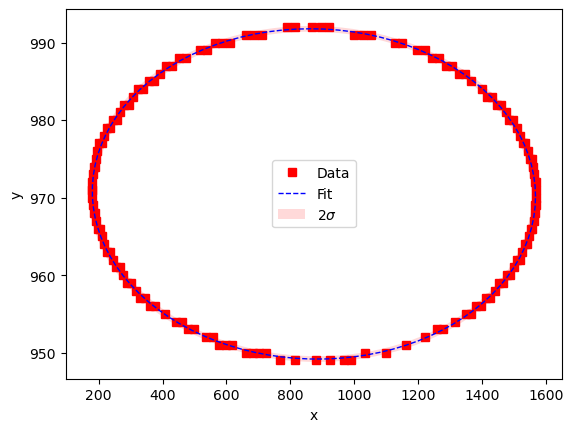

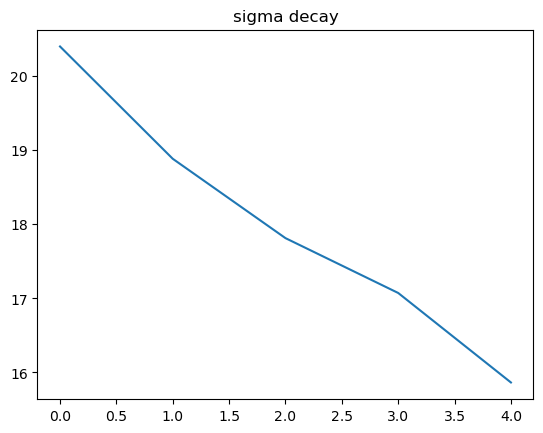

ID =  18
last sigma value =  10.13310834823642


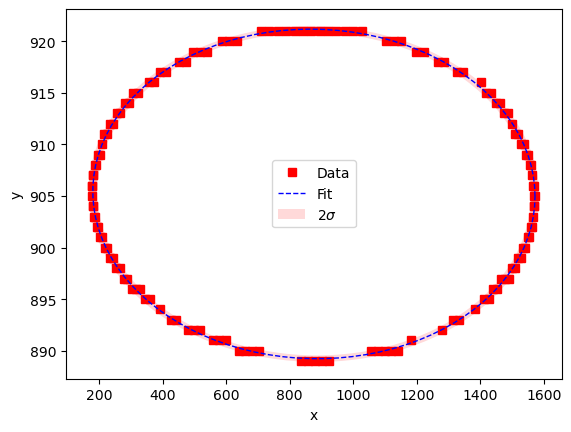

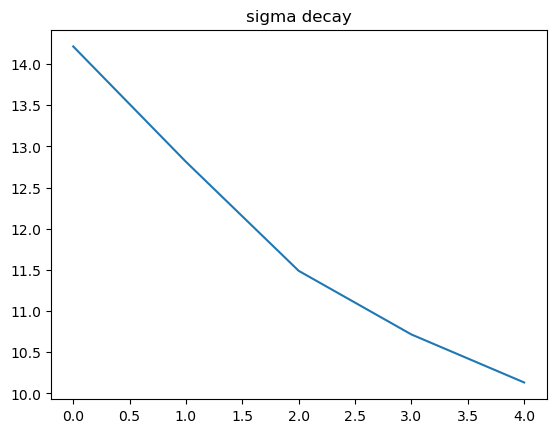

ID =  19
last sigma value =  8.077516977093183


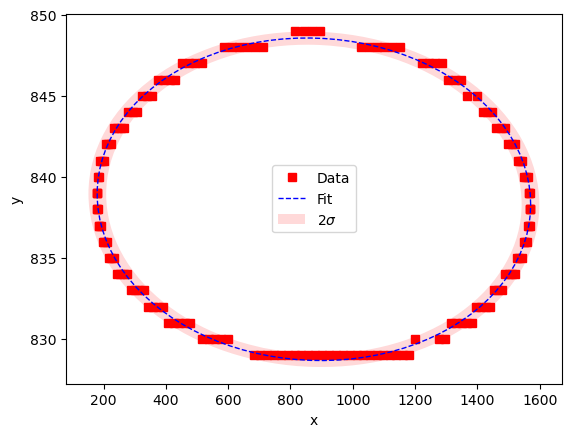

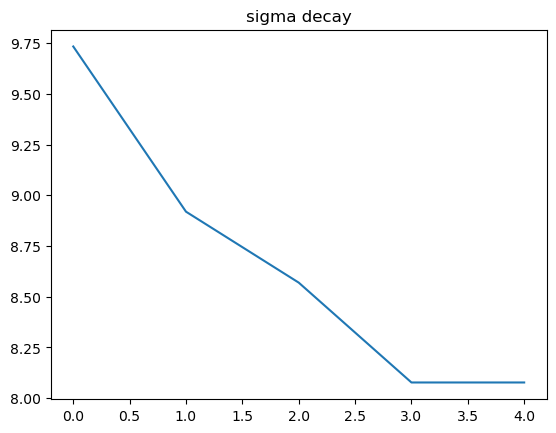

ID =  20
last sigma value =  2.438316750805825


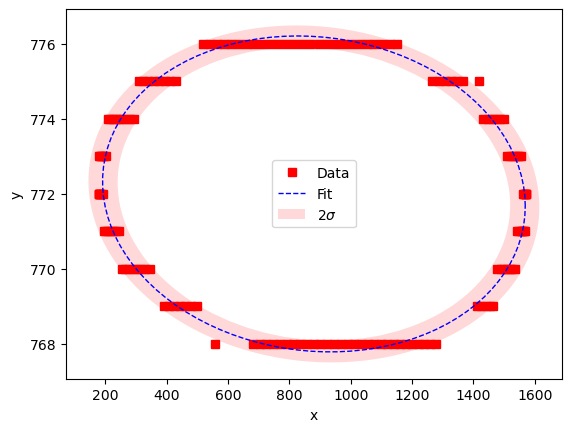

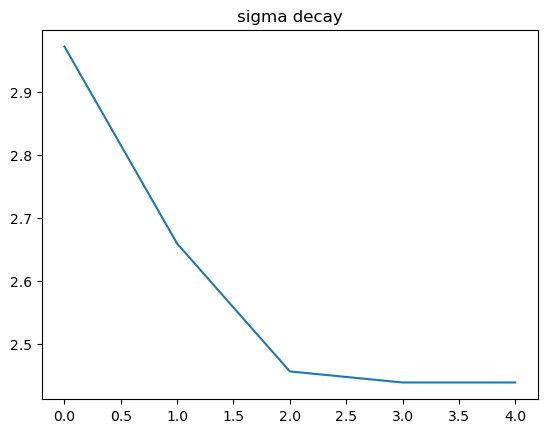

ID =  21
last sigma value =  1.6257325448095798


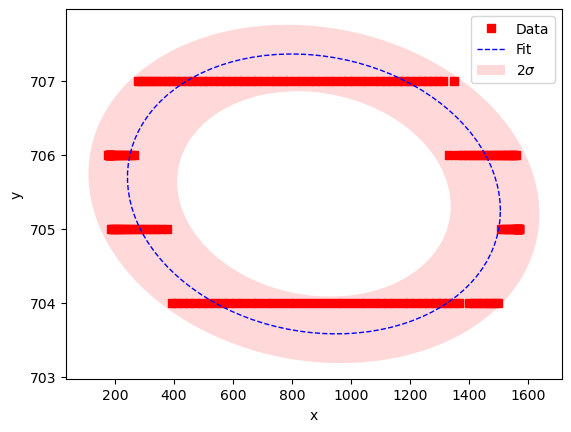

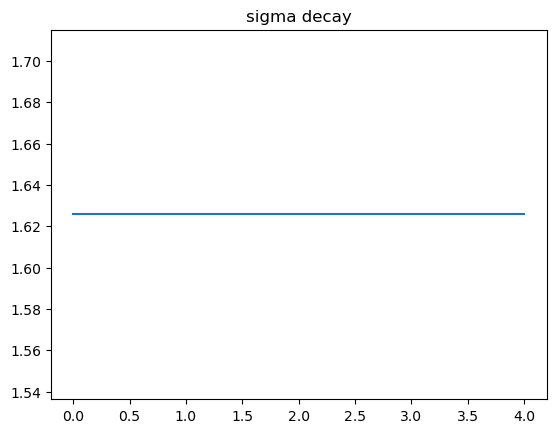

ID =  22
last sigma value =  4.139270962914452


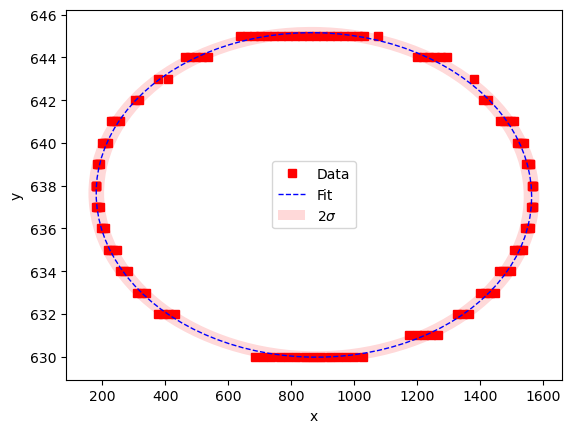

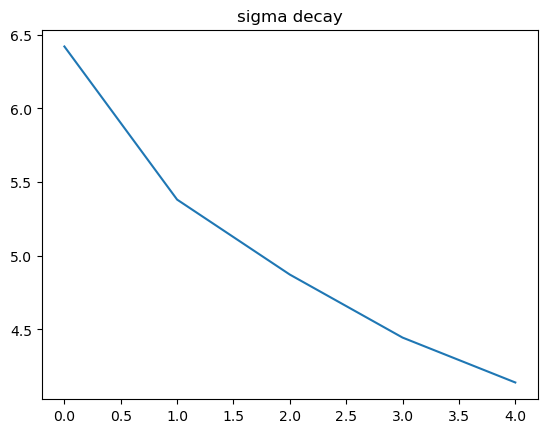

ID =  23
last sigma value =  9.272085594129749


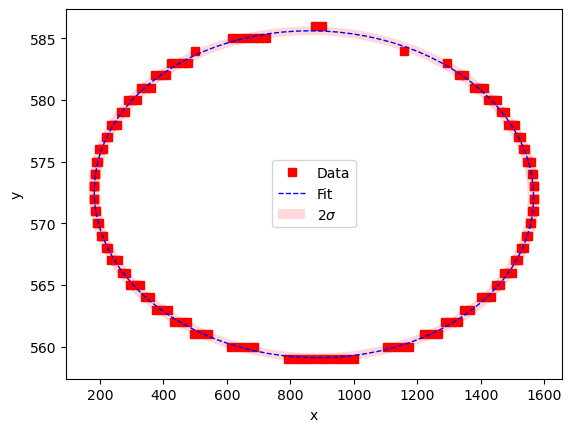

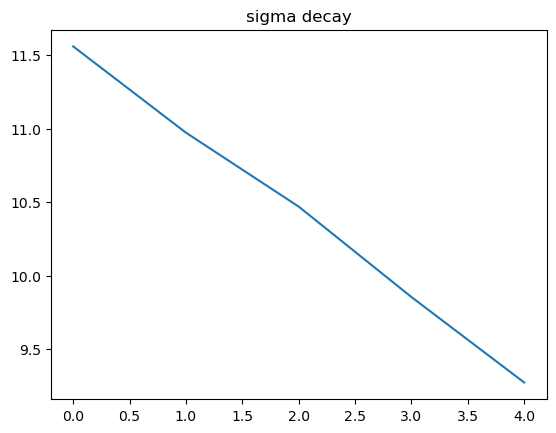

ID =  24
last sigma value =  12.124295272893505


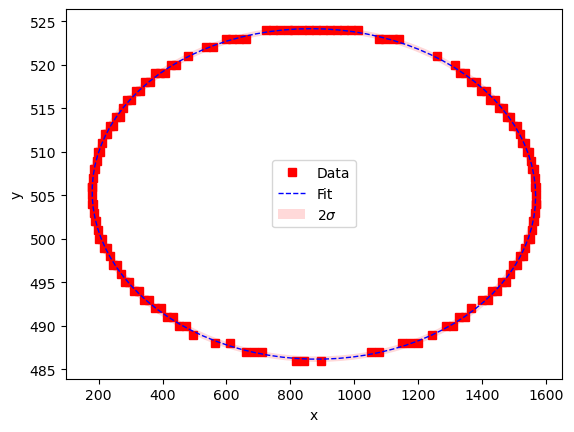

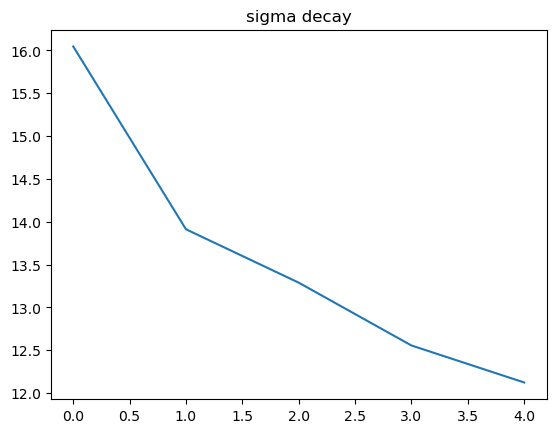

ID =  25
last sigma value =  19.720522220246494


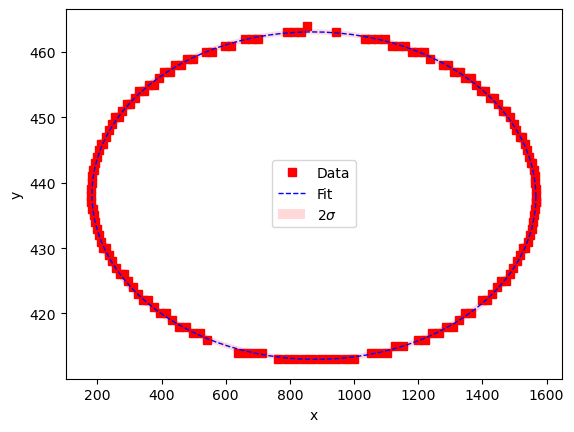

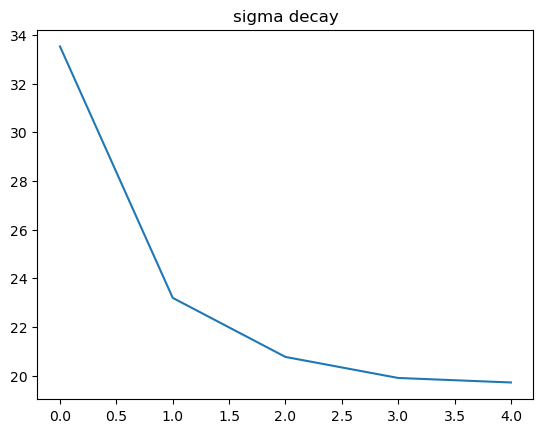

In [272]:
import matplotlib.patches as patches


trajectories_x = []
trajectories_y = []

for ID in trajectories:
    if trajectories[ID][1] is not None:
        trajectories_x.append(np.ravel(trajectories[ID][0][:, 0]).tolist())
        trajectories_y.append(np.ravel(trajectories[ID][0][:, 1]).tolist())

trajectories_x = np.array(trajectories_x)
trajectories_y = np.array(trajectories_y)

# number of iterations for outlier removal
N = 5

ell_all = []
err_all = []
Sigma_all = [] 
M = len(trajectories)
print('M = ', M)

for iii in range(M):
    
    print('ID = ', iii)

    sigma_ell = []

    x= trajectories_x[iii]
    y= trajectories_y[iii]

    for ell_ii in range(N):
        # do fitting
        params1 = fit(x,y)
        params1 = errors(x,y,params1)

        center, a, b, phi = convert(params1)
        c_up, c_do = confidence_area(x,y,[i.n for i in params1],f=2) 
        if convert(c_do) > convert(c_up):
            c_do, c_up = c_up,c_do

        # do the outlier removal
        mask1 = artist(c_up,ec='none') 
        mask2 = artist(c_do,ec='none') 

        # The ellipse1
        g_ell_center = getattr(mask1, "center")
        g_ell_width = getattr(mask1, "width")
        g_ell_height = getattr(mask1, "height")
        angle = getattr(mask1, "angle")

        g_ellipse = patches.Ellipse(g_ell_center, g_ell_width, g_ell_height, angle=angle, fill=False, edgecolor='skyblue', linewidth=2)
        ax.add_patch(g_ellipse)

        cos_angle = np.cos(np.radians(180.-angle))
        sin_angle = np.sin(np.radians(180.-angle))

        xc = x - g_ell_center[0]
        yc = y - g_ell_center[1]

        xct = xc * cos_angle - yc * sin_angle
        yct = xc * sin_angle + yc * cos_angle 

        rad_cc = (xct**2/(g_ell_width/2.)**2) + (yct**2/(g_ell_height/2.)**2)

        # The ellipse2
        g_ell_center2 = getattr(mask2, "center")
        g_ell_width2 = getattr(mask2, "width")
        g_ell_height2 = getattr(mask2, "height")
        angle2 = getattr(mask2, "angle")

        g_ellipse2 = patches.Ellipse(g_ell_center2, g_ell_width2, g_ell_height2, angle=angle2, fill=False, edgecolor='skyblue', linewidth=2)
        ax.add_patch(g_ellipse2)

        cos_angle2 = np.cos(np.radians(180.-angle2))
        sin_angle2 = np.sin(np.radians(180.-angle2))

        xc = x - g_ell_center[0]
        yc = y - g_ell_center[1]

        xct = xc * cos_angle - yc * sin_angle
        yct = xc * sin_angle + yc * cos_angle 

        rad_cc = (xct**2/(g_ell_width/2.)**2) + (yct**2/(g_ell_height/2.)**2)

                # The ellipse2
        g_ell_center2 = getattr(mask2, "center")
        g_ell_width2 = getattr(mask2, "width")
        g_ell_height2 = getattr(mask2, "height")
        angle2 = getattr(mask2, "angle")

        g_ellipse2 = patches.Ellipse(g_ell_center2, g_ell_width2, g_ell_height2, angle=angle2, fill=False, edgecolor='skyblue', linewidth=2)
        ax.add_patch(g_ellipse2)

        cos_angle2 = np.cos(np.radians(180.-angle2))
        sin_angle2 = np.sin(np.radians(180.-angle2))

        xc2 = x - g_ell_center2[0]
        yc2 = y - g_ell_center2[1]

        xct2 = xc2 * cos_angle2 - yc2 * sin_angle2
        yct2 = xc2 * sin_angle2 + yc2 * cos_angle2 

        rad_cc2 = (xct2**2/(g_ell_width2/2.)**2) + (yct2**2/(g_ell_height2/2.)**2)

        # define new X and Y as modified
        xy_array = np.array([x,y])
        indices1 = np.where(rad_cc2 <= 1.)[0]
        if len(indices1) > 0:
            modified_array1 = np.delete(xy_array, indices1, 1)
            indices2 = np.intersect1d(np.where(rad_cc >= 1.)[0], np.arange(modified_array1.shape[1]))
            if len(indices2) > 0:
                modified_array2 = np.delete(modified_array1, indices2, 1)
                x = modified_array2[0]
                y = modified_array2[1]
            else:
                x = modified_array1[0]
                y = modified_array1[1]
        else:
            pass
  
        sigma =  abs(((c_up-c_do)/2)[5])
        sigma_ell.append(sigma)


    ell = convert(params1)
    ell_all.append(ell)

    # plot of fit and confidence area
    fig,ax = plt.subplots()
    ax.plot(x,y,'sr',label='Data')
    ax.plot(*line([i.n for i in params1]),'--b',lw=1,label='Fit')
    ax.add_patch(artist(c_up,ec='none',fc='r',alpha=0.15,label=r'2$\sigma$'))
    ax.add_patch(artist(c_do,ec='none',fc='white'))
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig2,ax2 = plt.subplots()
    ax2.plot(sigma_ell)
    plt.title('sigma decay')

    print('last sigma value = ', sigma_ell[-1])
    plt.show()


In [273]:
len(x)

160

In [274]:
ID

26.0

In [275]:
# params1

In [276]:
# def fit(x,y):
#     D1 = np.vstack([x**2,x*y,y**2]).T
#     D2 = np.vstack([x,y,np.ones_like(x)]).T
#     S1,S2,S3 = D1.T @ D1, D1.T @ D2, D2.T @ D2
#     C1 = np.array([[0,0,2],[0,-1,0],[2,0,0]])
#     M = np.linalg.inv(C1) @ (S1 - S2 @ np.linalg.inv(S3) @ S2.T)
#     vec = np.linalg.eig(M)[1]
#     cond = 4*(vec[0]*vec[2]) - vec[1]**2
#     a1 = vec[:,np.nonzero(cond > 0)[0]]
#     return np.vstack([a1,np.linalg.inv(-S3) @ S2.T @ a1]).flatten()

In [277]:
# def errors(x, y, coeffs):
#     if coeffs.ndim != 1:
#         raise ValueError("Coefficients must be a 1D array")
#     z = np.vstack((x**2, x*y, y**2, x, y, np.ones_like(x)))
#     numerator = np.sum(((coeffs.reshape(1,6) @ z) - 1)**2)
#     denominator = (len(x) - 6) * np.sum(z**2, axis=1)
#     unc = np.sqrt(numerator / denominator)
#     return np.vstack((coeffs.ravel(), unc))

In [278]:
# idd = 21.0
# x= trajectories[idd][0][:, 0]
# y= trajectories[idd][0][:, 1]

In [279]:
# params = fit(x,y)
# params = errors(x,y,params)

In [280]:
# params

In [281]:
# z = np.vstack((x**2,x*y,y**2,x,y,np.ones_like(x)))
# print(z.shape)

In [282]:
# numerator = np.sum(((params @ z) - 1)**2)

In [283]:
# for ID in trajectories:
#     if trajectories[ID][1] is not None:
#         print(ID)
#         print(len(trajectories[ID][0]))
#         x = trajectories[ID][0][:, 0]
#         y = trajectories[ID][0][:, 1]
#         params = fit(x,y)
#         params = errors(x,y,params)

In [284]:
# params

In [285]:
# numerator

In [286]:
trajectories[ID][0][:, 0]

array([1365., 1346., 1327., 1307., 1286., 1265., 1244., 1221., 1198.,
       1174., 1151., 1127., 1102., 1077., 1052., 1026., 1000.,  974.,
        948.,  922.,  896.,  869.,  843.,  816.,  790.,  764.,  738.,
        712.,  687.,  662.,  637.,  612.,  588.,  565.,  542.,  519.,
        497.,  475.,  454.,  433.,  414.,  395.,  377.,  359.,  342.,
        326.,  311.,  296.,  283.,  270.,  258.,  247.,  236.,  227.,
        218.,  211.,  204.,  198.,  193.,  189.,  185.,  183.,  181.,
        181.,  181.,  182.,  184.,  186.,  190.,  194.,  199.,  205.,
        212.,  219.,  227.,  236.,  246.,  256.,  267.,  278.,  291.,
        303.,  317.,  331.,  345.,  360.,  376.,  392.,  409.,  426.,
        443.,  461.,  479.,  498.,  517.,  537.,  557.,  577.,  597.,
        618.,  639.,  660.,  681.,  702.,  724.,  746.,  768.,  790.,
        812.,  834.,  854.,  882.,  901.,  923.,  945.,  967.,  989.,
       1011., 1033., 1054., 1076., 1097., 1118., 1139., 1159., 1180.,
       1199., 1219.,

In [287]:
ell_all_array = np.array(ell_all,dtype=object)
M = ell_all_array.shape[0]
print('M:', M)
print(ell_all_array.shape)
print(len(ell_all_array))
print(ell_all_array[0][0][0])

M: 26
(26, 4)
26
874+/-4


In [288]:
x_cen_nominal = []
x_cen_std = []
for i in range(len(un.nominal_value(ell_all_array))):
    x_cen_nominal.append(un.nominal_value(ell_all_array[i][0][1]))
    x_cen_std.append(un.std_dev(un.nominal_value(ell_all_array[i][0][1])))
x_cen_nominal_arr = np.array(x_cen_nominal).reshape(M,1)
x_cen_std_arr = np.array(x_cen_std).reshape(M,1)

y_cen_nominal = []
y_cen_std = []
for i in range(len(un.nominal_value(ell_all_array))):
    y_cen_nominal.append(un.nominal_value(ell_all_array[i][0][0]))
    y_cen_std.append(un.std_dev(un.nominal_value(ell_all_array[i][0][0])))
y_cen_nominal_arr = np.array(y_cen_nominal).reshape(M,1)
y_cen_std_arr = np.array(y_cen_std).reshape(M,1)

a_nominal = []
a_std = []
for i in range(len(un.nominal_value(ell_all_array))):
    a_nominal.append(un.nominal_value(ell_all_array[i][1]))
    a_std.append(un.std_dev(un.nominal_value(ell_all_array[i][1])))
a_nominal_arr = np.array(a_nominal).reshape(M,1)
astd_arr = np.array(a_std).reshape(M,1) 


b_nominal = []
b_std = []
for i in range(len(un.nominal_value(ell_all_array))):
    b_nominal.append(un.nominal_value(ell_all_array[i][2]))
    b_std.append(un.std_dev(un.nominal_value(ell_all_array[i][2])))
b_nominal_arr = np.array(b_nominal).reshape(M,1)
bstd_arr = np.array(b_std).reshape(M,1)  


# angles_nominal = []
# angles_std = []
# for i in range(len(un.nominal_value(ell_all_array))):
#     angles_nominal.append(un.nominal_value(ell_all_array[i][3]))
#     angles_std.append(un.std_dev(un.nominal_value(ell_all_array[i][3])))
# angles_nominal_arr = np.array(angles_nominal).reshape(M,1)
# angles_std_arr = np.array(angles_std).reshape(M,1) 


angles_nominal = []
angles_std = []
for i in range(len(un.nominal_value(ell_all_array))):
    # Convert angle from radians to degrees
    angle_degrees = np.degrees(un.nominal_value(ell_all_array[i][3]))
    angles_nominal.append(angle_degrees)
    angles_std.append(np.degrees(un.std_dev(un.nominal_value(ell_all_array[i][3]))))
    
# angles_nominal_arr = np.array(angles_nominal).reshape(M,1)
# angles_std_arr = np.array(angles_std).reshape(M,1)

# angles_nominal = []
# angles_std = []
# for i in range(len(un.nominal_value(ell_all_array))):
#     # Convert angle from degrees to radians
#     angle_radians = np.radians(un.nominal_value(ell_all_array[i][3]))
#     angles_nominal.append(angle_radians)
#     angles_std.append(np.radians(un.std_dev(un.nominal_value(ell_all_array[i][3]))))
    
# angles_nominal_arr = np.array(angles_nominal).reshape(M,1)
# angles_std_arr = np.array(angles_std).reshape(M,1)



# centers_nominal = []
# centers_std = []
# for i in range(len(un.nominal_value(ell_all_array))):
#     centers_nominal.append(un.nominal_value(ell_all_array[i][0][0]),un.nominal_value(ell_all_array[i][0][1]))
#     centers_std.append(un.std_dev(un.nominal_value(un.nominal_value(ell_all_array[i][0][0]),un.nominal_value(ell_all_array[i][0][1]))))
# centers_nominal_arr = np.array(centers_nominal).reshape(M,1)
# centers_std_arr = np.array(centers_std).reshape(M,1)

In [289]:
heights = x_cen_nominal[:]
x_centers = y_cen_nominal[:]
y_centers = x_cen_nominal[:]
major_axes = a_nominal[:]
minor_axes = b_nominal[:]
angles = angles_nominal[:]

In [290]:
np.array(minor_axes).shape

(26,)

In [291]:
x_centers

[874.2946418735426,
 874.6227662801584,
 875.8421720435332,
 875.0262822957131,
 875.4576114780334,
 874.2873072328758,
 874.2141036243872,
 875.2584995820919,
 874.7380660577363,
 875.2395150155096,
 875.9085522320885,
 875.6096342828288,
 876.56293730346,
 876.3462827361571,
 873.8880797630542,
 874.0214623935938,
 877.133348858961,
 873.7448231121631,
 876.0910796370949,
 875.2104464921885,
 879.8388658694627,
 874.4028414145627,
 872.3332703128435,
 874.1471814815621,
 873.2835398779434,
 874.8107539328196]

In [292]:
y_centers

[2069.092963844554,
 2012.3321312633054,
 1947.0672575530252,
 1881.9996807909442,
 1818.1922301545817,
 1757.9422763687792,
 1698.6073408857922,
 1631.2154584715029,
 1564.7152936787577,
 1498.1935525944525,
 1432.2835488246583,
 1365.1233754341786,
 1298.791466856065,
 1231.7076257987276,
 1165.1979865292099,
 1097.6462248596263,
 1035.9666232547106,
 970.4800292338263,
 905.1981740574745,
 838.6191554943281,
 771.9958166902675,
 705.4729306016396,
 637.5662866144842,
 572.3551873655217,
 505.1615966948754,
 438.034387482575]

In [293]:
minor_axes

[111.19475429702014,
 114.83428940359816,
 109.1289190902257,
 103.15881247945563,
 97.40418667888677,
 91.52782826766956,
 85.31016120269432,
 78.88891442027118,
 73.36291056638328,
 67.25990279074847,
 61.8312433627313,
 55.76397995193086,
 50.2455169752458,
 44.099655794535046,
 38.354520954706956,
 32.52810873782962,
 27.149538574282875,
 21.301377062485116,
 15.968522985441986,
 9.94017199791018,
 4.205503509440363,
 1.876103821217421,
 7.588629323315753,
 13.249789722578898,
 18.984083511471223,
 25.05272723076171]

In [294]:
major_axes

[702.5925876420187,
 693.0944685178409,
 691.6295736707184,
 690.953362330385,
 690.7510611083678,
 692.9875951434881,
 699.10823509394,
 698.8870957452021,
 699.1129725741113,
 699.1845725799756,
 699.5015446067785,
 699.2235359732388,
 699.013388834784,
 698.1174361372089,
 696.3029468152555,
 697.7412561385615,
 696.8544266925413,
 693.8245119446864,
 696.2584020718363,
 695.6562452745384,
 689.0574618238506,
 632.0894609520114,
 692.4737493989243,
 692.1966369597375,
 693.2358918115211,
 691.8216755981591]

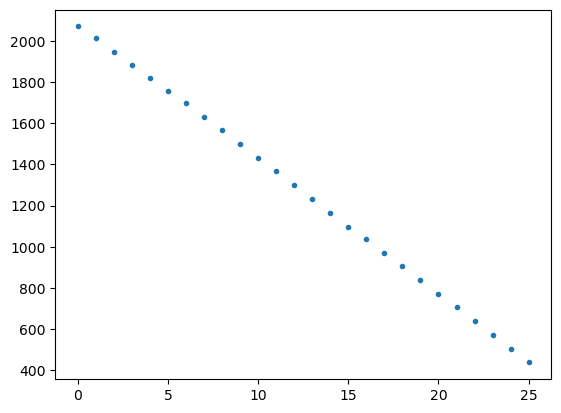

In [296]:
plt.plot(heights,'.')

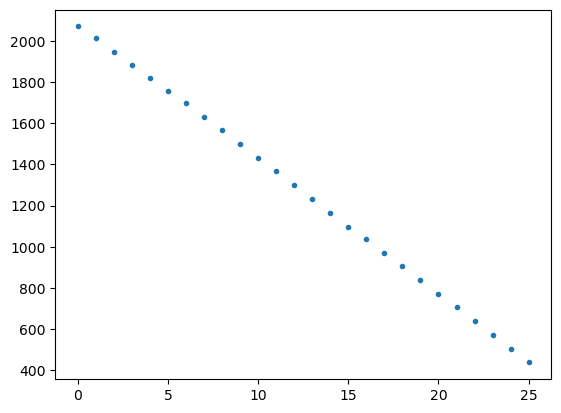

In [297]:
plt.plot(y_centers,'.')

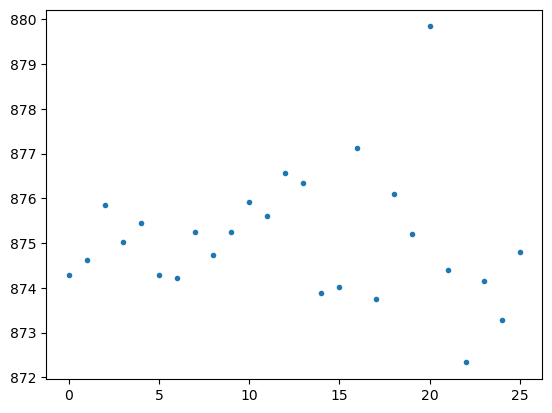

In [298]:
plt.plot(x_centers,'.')

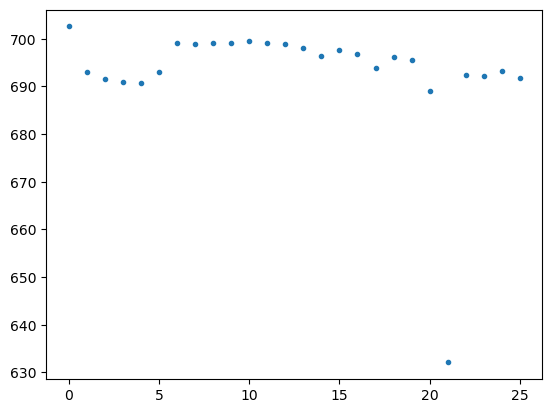

In [299]:
plt.plot(major_axes,'.')

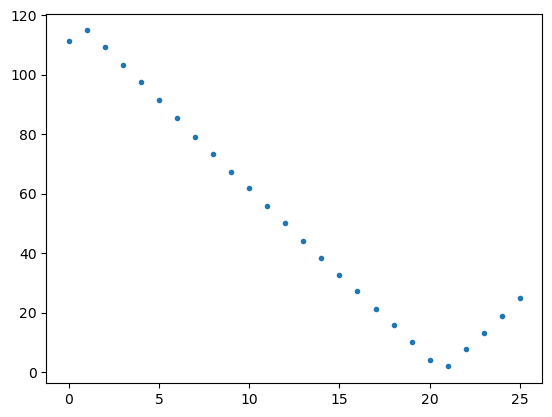

In [300]:
plt.plot(minor_axes,'.')

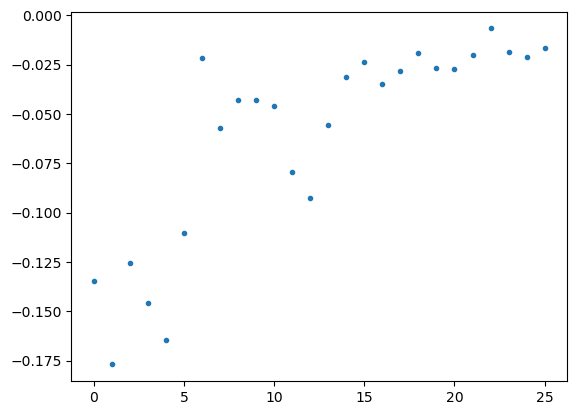

In [302]:
plt.plot(angles,'.')

In [303]:
# import numpy as np
# from scipy.optimize import curve_fit

# # define function for ellipse fitting
# def ellipse_func(x, a, b, xc, yc, theta):
#     # equation for an ellipse
#     x0 = xc
#     y0 = yc
#     A = (np.cos(theta)/a)**2 + (np.sin(theta)/b)**2
#     B = 2*np.sin(theta)*np.cos(theta)*(1/a**2 - 1/b**2)
#     C = (np.sin(theta)/a)**2 + (np.cos(theta)/b)**2
#     return A*(x[0]-x0)**2 + B*(x[0]-x0)*(x[1]-y0) + C*(x[1]-y0)**2 - 1

# # define initial guess for ellipse parameters
# xc_guess = np.mean(x_centers)
# yc_guess = np.mean(y_centers)
# a_guess = np.mean(major_axes)
# b_guess = np.mean(minor_axes)
# theta_guess = np.mean(angles)

# # fit ellipse parameters for all heights
# params_list = []
# for i in range(len(heights)):
#     p0 = [a_guess, b_guess, xc_guess, yc_guess, theta_guess]
#     xdata = np.array([x_centers[i], y_centers[i]])
#     ydata = np.zeros(len(x_centers[i]))
#     popt, pcov = curve_fit(ellipse_func, (xdata, ydata), minor_axes[i]**2/major_axes[i]**2, p0=p0)
#     params_list.append(popt)

# # compute intersection point of all minor axes
# A_matrix = np.zeros((3, 3))
# B_vector = np.zeros(3)
# for i in range(len(heights)):
#     a_i, b_i, xc_i, yc_i, theta_i = params_list[i]
#     cos_theta_i = np.cos(theta_i)
#     sin_theta_i = np.sin(theta_i)
#     A_matrix[0, 0] += cos_theta_i**2/a_i**2 + sin_theta_i**2/b_i**2
#     A_matrix[0, 1] += (1/a_i**2 - 1/b_i**2)*cos_theta_i*sin_theta_i
#     A_matrix[0, 2] += -xc_i*cos_theta_i**2/a_i**2 - yc_i*cos_theta_i*sin_theta_i/a_i**2
#     A_matrix[1, 1] += sin_theta_i**2/a_i**2 + cos_theta_i**2/b_i**2
#     A_matrix[1, 2] += -yc_i*sin_theta_i**2/a_i**2 - xc_i*cos_theta_i*sin_theta_i/b_i**2
#     A_matrix[2, 2] += 1
#     B_vector[0] += -source_to_detector*cos_theta_i/a_i**2
#     B_vector[1] += -source_to_detector*sin_theta_i/b_i**2
#     B_vector[2] += xc_i*source_to_detector*cos_theta_i/a_i**2 + yc_i*source_to_detector*sin_theta_i/b_i**2

# intersection_point = np.linalg.solve(A_matrix, B_vector)

# # compute projection of intersection point onto detector plane
# projection_point = intersection_point[:2] - intersection_point[2]/source_to_detector * np.array([x_centers[0], y_centers[0]])

# print("Intersection point:", intersection_point)
# print("Projection point:", projection_point)


In [304]:
np.array(minor_axes).shape



(26,)

In [305]:
# import numpy as np
# import cv2

# # Calculate endpoints of line segments
# line_points = []
# for i in range(len(X_centers)):
#     x0 = X_centers[i]
#     y0 = y_centers[i]
#     x1 = x0 + major_axes[i] * np.cos(angles[i])
#     y1 = y0 - major_axes[i] * np.sin(angles[i])
#     line_points.append([x0, y0, x1, y1])
# line_points = np.array(line_points)

In [306]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # select a line segment to plot
# line_idx = 10

# # get the center of the line segment
# x0, y0, x1, y1 = line_points[line_idx]
# center = np.array([(x0 + x1) / 2, (y0 + y1) / 2])

# # find the ellipse that contains the center of the line segment
# distances = np.linalg.norm(np.array([X_centers, y_centers]) - center.reshape((2, 1)), axis=0)
# ellipse_idx = np.argmin(distances)

# # plot the ellipse
# fig, ax = plt.subplots()
# ellipse = patches.Ellipse(xy=(X_centers[ellipse_idx], y_centers[ellipse_idx]),
#                           width=2 * major_axes[ellipse_idx],
#                           height=2 * minor_axes[ellipse_idx],
#                           angle=np.degrees(angles[ellipse_idx]),
#                           edgecolor='r',
#                           facecolor='none')
# ax.add_patch(ellipse)

# # plot the line segment
# ax.plot([x0, x1], [y0, y1], 'b')

# # set the axis limits to include the ellipse and line segment
# ax.set_xlim(X_centers[ellipse_idx] - 2 * major_axes[ellipse_idx], X_centers[ellipse_idx] + 2 * major_axes[ellipse_idx])
# ax.set_ylim(y_centers[ellipse_idx] - 2 * major_axes[ellipse_idx], y_centers[ellipse_idx] + 2 * major_axes[ellipse_idx])

# # show the plot
# plt.show()


In [307]:

# Calculate endpoints of line segments
line_points = []
for i in range(len(x_centers)):
    x0 = y_centers[i]
    y0 = x_centers[i]
    x1 = x0 + minor_axes[i] * np.cos((angles[i]))
    y1 = y0 + minor_axes[i] * np.sin((angles[i]))
    line_points.append([x0, y0, x1, y1])
line_points = np.array(line_points)


In [308]:
line_points.shape

(26, 4)

In [309]:
line_points

array([[2069.09296384,  874.29464187, 2179.2783965 ,  859.34660474],
       [2012.33213126,  874.62276628, 2125.3735699 ,  854.41021637],
       [1947.06725755,  875.84217204, 2055.3354429 ,  862.1629534 ],
       [1881.99968079,  875.0262823 , 1984.06628792,  860.05469914],
       [1818.19223015,  875.45761148, 1914.27872992,  859.49014001],
       [1757.94227637,  874.28730723, 1848.91245593,  864.19920645],
       [1698.60734089,  874.21410362, 1783.89793761,  872.38716226],
       [1631.21545847,  875.25849958, 1709.97478098,  870.73855086],
       [1564.71529368,  874.73806606, 1638.01114845,  871.6020942 ],
       [1498.19355259,  875.23951502, 1565.39098447,  872.34129613],
       [1432.28354882,  875.90855223, 1494.04929121,  873.06325384],
       [1365.12337543,  875.60963428, 1420.71141506,  871.18342699],
       [1298.79146686,  876.5629373 , 1348.82249566,  871.92525119],
       [1231.7076258 ,  876.34628274, 1275.73958858,  873.90376453],
       [1165.19798653,  873.888079

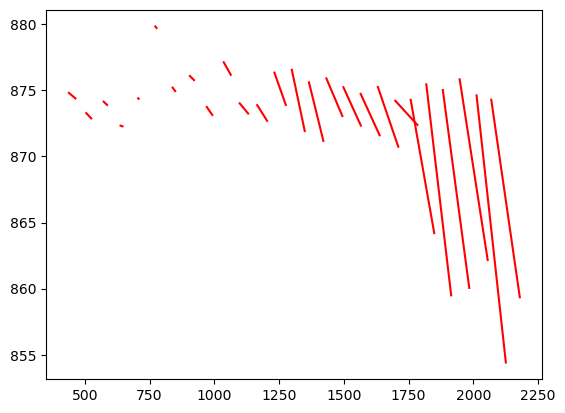

In [310]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for x0, y0, x1, y1 in line_points:
    ax.plot([x0, x1], [y0, y1], color='red')

# ax.set_aspect('equal')
plt.show()


In [311]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# # select a line segment to plot
# line_idx = 0

# # get the center of the line segment
# x0, y0, x1, y1 = line_points[line_idx]
# center = np.array([(x0 + x1) / 2, (y0 + y1) / 2])

# # find the ellipse that contains the center of the line segment
# distances = np.linalg.norm(np.array([x_centers, y_centers]) - center.reshape((2, 1)), axis=0)
# ellipse_idx = np.argmin(distances)

# # plot the ellipse
# fig, ax = plt.subplots()
# ellipse = patches.Ellipse(xy=(x_centers[ellipse_idx], y_centers[ellipse_idx]),
#                           width=2 * minor_axes[ellipse_idx],
#                           height=2 * major_axes[ellipse_idx],
#                           angle=angles[ellipse_idx],
#                           edgecolor='r',
#                           facecolor='none')
# ax.add_patch(ellipse)

# # plot the line segment
# ax.plot([x0, x1], [y0, y1], 'b')

# # # set the axis limits to include the ellipse and line segment
# # ax.set_xlim(x_centers[ellipse_idx] - 2 * minor_axes[ellipse_idx], x_centers[ellipse_idx] + 2 * minor_axes[ellipse_idx])
# # ax.set_ylim(y_centers[ellipse_idx] - 2 * major_axes[ellipse_idx], y_centers[ellipse_idx] + 2 * major_axes[ellipse_idx])

# plt.show()
# print(np.radians(angle))

In [312]:
# Algebraic solution 
lines = []
for line_point in line_points:
    x0, y0, x1, y1 = line_point
    if x0 != x1:
        k = (y1 - y0) / (x1 - x0)
        b = y0 - k * x0
        lines.append([k, -1, -b])  # convert line equation to the form ax + by = c
    else:
        lines.append([None, None, x0])  # add a line with vertical slope

# Find intersection point of lines using linear algebra
A = np.array([[line[0], line[1]] for line in lines if line[0] is not None])  # remove vertical lines
b = np.array([line[2] for line in lines if line[0] is not None])
x_int, y_int = np.linalg.lstsq(A, b, rcond=None)[0]

print(f"Intersection point: ({x_int}, {y_int})")

Intersection point: (2071.3995817147243, 846.2625671822263)


In [313]:
# Line fitting least square optimization 
from scipy.optimize import least_squares

def fun(x, lines):
    a, b = x
    residuals = []
    for line in lines:
        k, _, b_ = line
        residuals.append(k * a - b + b_)
    return residuals

x0 = np.array([0, 0])
res = least_squares(fun, x0, args=(lines,))
x_int, y_int = res.x

print(f"Intersection point: ({-x_int}, {-y_int})")

Intersection point: (2071.399578490715, 846.2625673774795)


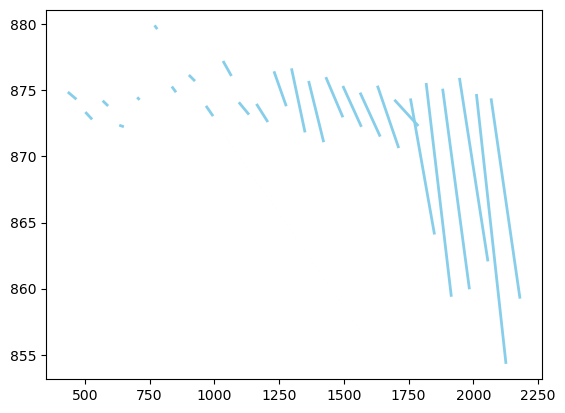

In [314]:
# # Plot selected line segment on corresponding ellipse
# for i in range(len(x_centers)):
#     ellipse = patches.Ellipse((x_centers[i], y_centers[i]), 2 * minor_axes[i], 2 * major_axes[i], np.rad2deg(angles[i]), fill=False, edgecolor='red')
#     ax.add_patch(ellipse)
#     line_point = line_points[i]
#     x0, y0, x1, y1 = line_point
#     line = patches.ConnectionPatch((x0, y0), (x1, y1), "data", lw=2, color='green', arrowstyle='->', shrinkA=5, shrinkB=5)
#     ax.add_patch(line)

# Plot fitted line on ellipse and line segment
for i in range(len(x_centers)):

    line_point = line_points[i]
    x0, y0, x1, y1 = line_point
    line = patches.ConnectionPatch((x0, y0), (x1, y1), "data", lw=2, color='green', arrowstyle='->', shrinkA=5, shrinkB=5)
    ax.add_patch(line)
    x_center = x_centers[i]
    y_center = y_centers[i]
    a = major_axes[i]
    b = minor_axes[i]
    phi = angles[i]
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    x0_norm = (x0 - x_center) * cos_phi + (y0 - y_center) * sin_phi
    y0_norm = -(x0 - x_center) * sin_phi + (y0 - y_center) * cos_phi
    x1_norm = (x1 - x_center) * cos_phi + (y1 - y_center) * sin_phi
    y1_norm = -(x1 - x_center) * sin_phi + (y1 - y_center) * cos_phi
    k = (y1_norm - y0_norm) / (x1_norm - x0_norm)
    b = y0_norm - k * x0_norm
    x_fit = np.linspace(x0_norm, x1_norm, 100)
    y_fit = k * x_fit + b
    x_fit_global = x_fit * cos_phi - y_fit * sin_phi + x_center
    y_fit_global = x_fit * sin_phi + y_fit * cos_phi + y_center
    plt.plot(x_fit_global, y_fit_global, color='skyblue', linewidth=2)
    
    


In [315]:


# Plot fitted line on ellipse and line segment
for i in range(len(x_centers)):
    ellipse = patches.Ellipse((x_centers[i], y_centers[i]), 2 * minor_axes[i], 2 * major_axes[i], np.rad2deg(angles[i]), fill=False, edgecolor='red')
    ax.add_patch(ellipse)
    line_point = line_points[i]
    x0, y0, x1, y1 = line_point
    line_direction = np.array([x1 - x0, y1 - y0])
    line_direction /= np.linalg.norm(line_direction)
    x1 += line_direction[0] * 10000
    y1 += line_direction[1] * 10000
    line = patches.ConnectionPatch((x0, y0), (x1, y1), "data", lw=2, color='blue', arrowstyle='->', shrinkA=5, shrinkB=5)
    ax.add_patch(line)
    x_center = x_centers[i]
    y_center = y_centers[i]
    a = major_axes[i]
    b = minor_axes[i]
    phi = angles[i]
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    x0_norm = (x0 - x_center) * cos_phi + (y0 - y_center) * sin_phi
    y0_norm = -(x0 - x_center) * sin_phi + (y0 - y_center) * cos_phi
    x1_norm = (x1 - x_center) * cos_phi + (y1 - y_center) * sin_phi
    y1_norm = -(x1 - x_center) * sin_phi + (y1 - y_center) * cos_phi
    k = (y1_norm - y0_norm) / (x1_norm - x0_norm)
    b = y0_norm - k * x0_norm
    x_fit = np.linspace(x0_norm, x1_norm, 100)
    y_fit = k * x_fit + b
    x_fit_global = x_fit * cos_phi - y_fit * sin_phi + x_center
    y_fit_global = x_fit * sin_phi + y_fit * cos_phi + y_center
    plt.plot(x_fit_global, y_fit_global, color='skyblue', linewidth=2)


TypeError: Ellipse.__init__() takes 4 positional arguments but 5 were given

In [316]:
# Line fitting RANSAC 

from sklearn import linear_model

lines = []
threshold = 10  # distance threshold for RANSAC
num_iterations = 100  # number of iterations for RANSAC

for line_point in line_points:
    x0, y0, x1, y1 = line_point
    x = np.array([x0, x1]).reshape(-1, 1)
    y = np.array([y0, y1])
    ransac_model = linear_model.RANSACRegressor(base_estimator=linear_model.LinearRegression(),
                                                residual_threshold=threshold,
                                                max_trials=num_iterations)
    ransac_model.fit(x, y)
    k, b = ransac_model.estimator_.coef_, ransac_model.estimator_.intercept_
    lines.append([k[0], -1, b])  # convert line equation to the form ax + by = c


# Find intersection point of lines using linear algebra
A = np.array([[line[0], line[1]] for line in lines])
b = np.array([-line[2] for line in lines])
x_int, y_int = np.linalg.lstsq(A, b, rcond=None)[0]

# Print results
print(f"Intersection point: ({x_int},{y_int})")


Intersection point: (2071.3995817147133,846.2625671822269)


/Users/kaestner/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
/Users/kaestner/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
/Users/kaestner/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
/Users/kaestner/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.1 and will be removed in 1.3.
  warnings.warn(
/Users/kaestner/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ransac.py:343: FutureWarning: `base_estimator` was renamed to `estimator` in ve

/var/folders/hj/l3z3z7bj663f4wp4vlx69lt40000nw/T/ipykernel_33351/1169246278.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(trajectories[ID][0][:, 0], trajectories[ID][0][:, 1],s=20, marker='o',cmap = 'RdYlBu_r')


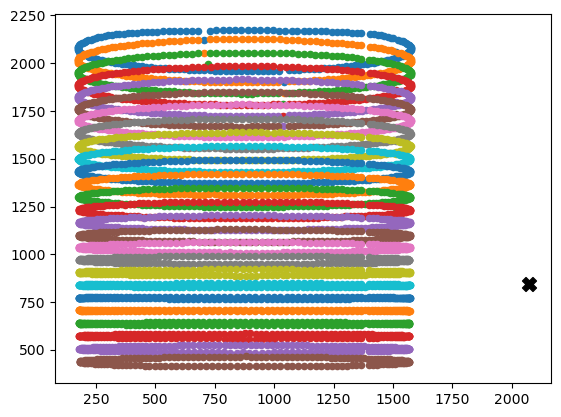

In [317]:
for ID in trajectories:
    if trajectories[ID][1] is not None:
         plt.scatter(trajectories[ID][0][:, 0], trajectories[ID][0][:, 1],s=20, marker='o',cmap = 'RdYlBu_r')
# plt.scatter(777.9517768474656, 911.6863451903185, marker='X', s=100, c='black')
# plt.scatter(x_int,y_int, marker='X', s=100, c='black')
plt.scatter(x_int,y_int, marker='X', s=100, c='black')



In [548]:
2176-957.1


1218.9

### COR

In [319]:
heights = np.array(y_cen_nominal[:])
x_centers = np.array(y_cen_nominal[:])
y_centers = np.array(x_cen_nominal[:])
major_axes = np.array(a_nominal[:])
minor_axes = np.array(b_nominal[:])
angles = np.array(angles_nominal[:])

outlier values:  [array([2069.09296384]), array([2012.33213126]), array([1947.06725755]), array([1881.99968079]), array([1818.19223015]), array([1757.94227637])]
[[0.00051373]]
number of pixels the center of rotation deviated from top to bottom of the tomogram:  7.5055955566191415
Center of rotation vertical:  875.1183643939507
Tilt slope:  [0.00051373]
The tilt of the center of rotation in degrees:  [[0.02943465]]


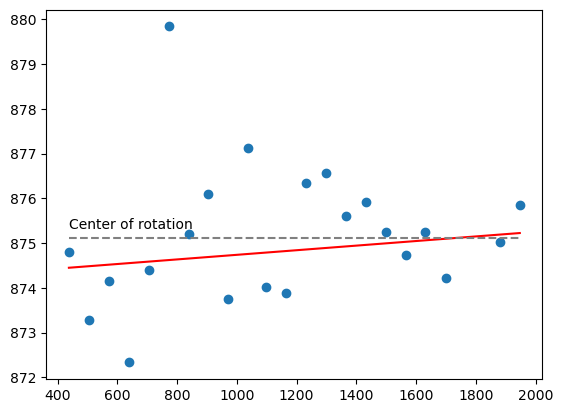

In [320]:
import uncertainties as un

x_centres=[]
y_centres=[]

for i in range(len(ell_all_array)):
    x_centres.append(ell_all_array[i][0][1])
    y_centres.append(ell_all_array[i][0][0])
    

arr_x = np.array(x_centres)

arr_x_nominal = []
arr_x_std = []
for iii in range(len(un.nominal_value(arr_x))):
    arr_x_nominal.append(un.nominal_value(un.nominal_value(arr_x)[iii]))
    arr_x_std.append(un.std_dev(un.nominal_value(arr_x)[iii]))
arr_x_nominal_arr = np.array(arr_x_nominal).reshape(M,1)
arr_x_std_arr = np.array(arr_x_std).reshape(M,1)


arr_y = np.array(y_centres)

arr_y_nominal = []
arr_y_std = []
for iii in range(len(un.nominal_value(arr_y))):
    arr_y_nominal.append(un.nominal_value(un.nominal_value(arr_y)[iii]))
    arr_y_std.append(un.std_dev(un.nominal_value(arr_y)[iii]))
arr_y_nominal_arr = np.array(arr_y_nominal).reshape(M,1)
arr_y_std_arr = np.array(arr_y_std).reshape(M,1)


# Removing the outlier in the data 
elements_x = arr_x_nominal_arr
elements_y = arr_y_nominal_arr


median_x = np.median(elements_x, axis=0)
sd_x = np.std(elements_x, axis=0)

outlier_x = [x for x in elements_x if (x > median_x + 1 * sd_x)]
print('outlier values: ', outlier_x)



for i in range(len(outlier_x)):
    index_x = np.where(elements_x == outlier_x[i-1])
    final_list_x_1 = np.array(np.delete(elements_x, index_x)).reshape(-1, 1)
    final_list_y_1 = np.array(np.delete(elements_y, index_x)).reshape(-1, 1)
    index_x_2 = np.where(final_list_x_1 == outlier_x[i])
    final_list_x = np.array(np.delete(final_list_x_1, index_x_2)).reshape(-1, 1)
    final_list_y = np.array(np.delete(final_list_y_1, index_x_2)).reshape(-1, 1)



# Using RANSACRegressor for minimum sensitivity to the outliers      
from sklearn.linear_model import RANSACRegressor  # https://developer.nvidia.com/blog/dealing-with-outliers-using-three-robust-linear-regression-models/


ransac = RANSACRegressor(random_state=10).fit(final_list_x, final_list_y)
plotline_y = np.arange(final_list_x.min(), final_list_x.max()).reshape(-1, 1)
a = ransac.predict(plotline_y)
ransac_coef = ransac.estimator_.coef_
print(ransac_coef)


# print(final_list_y.shape)
# print(final_list_x.shape)
devaition_range = final_list_y.max()- final_list_y.min()
print('number of pixels the center of rotation deviated from top to bottom of the tomogram: ', np.abs(devaition_range))
COR_new = np.median(final_list_y) 
print('Center of rotation vertical: ', COR_new)
# form above (cell) estimation:
print('Tilt slope: ', ransac_coef.ravel())
# print('Tilt degree: ', ransac_coef.ravel())

#### Final value of COR can be obtained by subtractin of the projection value taken 
tilt_angle = np.degrees(np.arctan(ransac_coef))
print("The tilt of the center of rotation in degrees: ", tilt_angle)

plt.plot(plotline_y,a,'r')
plt.scatter(final_list_x, final_list_y)
plt.hlines(COR_new, xmin = final_list_x.min() , xmax =final_list_x.max() , colors='gray', linestyles='--', label='')
plt.text(final_list_x.min(), COR_new+0.2, 'Center of rotation');


In [321]:
final_list_x

array([[1947.06725755],
       [1881.99968079],
       [1698.60734089],
       [1631.21545847],
       [1564.71529368],
       [1498.19355259],
       [1432.28354882],
       [1365.12337543],
       [1298.79146686],
       [1231.7076258 ],
       [1165.19798653],
       [1097.64622486],
       [1035.96662325],
       [ 970.48002923],
       [ 905.19817406],
       [ 838.61915549],
       [ 771.99581669],
       [ 705.4729306 ],
       [ 637.56628661],
       [ 572.35518737],
       [ 505.16159669],
       [ 438.03438748]])

In [322]:
final_list_y

array([[875.84217204],
       [875.0262823 ],
       [874.21410362],
       [875.25849958],
       [874.73806606],
       [875.23951502],
       [875.90855223],
       [875.60963428],
       [876.5629373 ],
       [876.34628274],
       [873.88807976],
       [874.02146239],
       [877.13334886],
       [873.74482311],
       [876.09107964],
       [875.21044649],
       [879.83886587],
       [874.40284141],
       [872.33327031],
       [874.14718148],
       [873.28353988],
       [874.81075393]])

In [323]:
vpiercing = 2176-y_int
hpiercing = 800


In [324]:
vpiercing

1329.737432817773

In [325]:
hpiercing

800

### SSD and SOD

SOD median=  58.00528561586552
SDD median=  554.2315827012828
Magnification median=  9.604211066689986
Magnification ratio=  9.5548461974936
SOD stdev=  674.982390436722
SDD stdev=  5977.478830972328
SOD mean=  330.8287440023704
SDD mean=  3055.323325152897


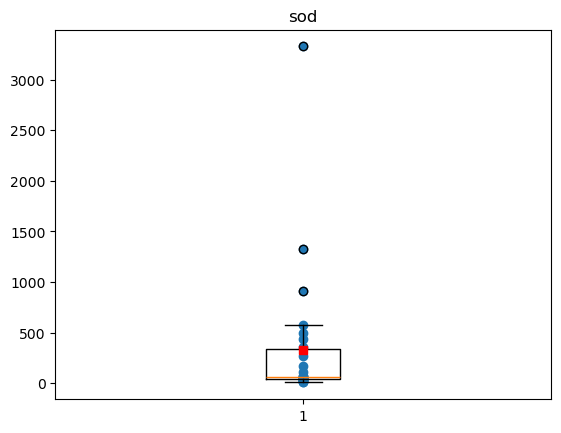

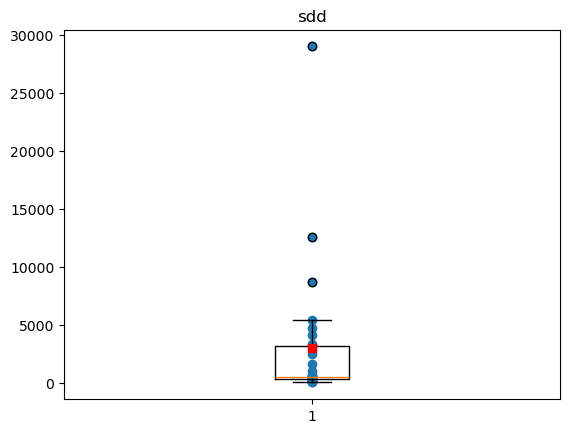

In [326]:
import numpy as np
import uncertainties as un

pixelSize = 0.138   # mm
R = 10              # mm
# c0=itemList(findBeadsWS(tcal[0,:,:]))
sod = []
sdd = []
mag = []
cte = pixelSize/R
for idx in range(ell_all_array.shape[0]) :
    ha=(ell_all_array[idx][0][1]-ell_all_array[idx][2]-vpiercing) * pixelSize
    hb=(ell_all_array[idx][0][1]+ell_all_array[idx][2]-vpiercing) * pixelSize
#     h=0
#     if idx in range(ell_all_array.shape[0]) :
#         h = (c0[idx][0]-vpiercing)*pixelSize
    est_sod= (hb+ha)*R/(hb-ha)
#     est_sdd= ((est_sod-R)*hb)/h
    sod.append(np.abs(est_sod))
#     sdd.append(np.abs(est_sdd))
#     print("h: {0:0.3f}, S0D: {1:0.2f}, SDD: {2:0.2f}, magn: {3:0.2f}".format,(h,est_sod, est_sdd,est_sdd/est_sod))

    magnification_each_elipse = cte * (ell_all_array[idx][1]) 
    sdd_each_elipse = magnification_each_elipse * est_sod
    sdd.append(np.abs(sdd_each_elipse))
    mag.append(magnification_each_elipse)


sod_mean = np.median([un.nominal_value(x) for x in sod])
sdd_mean = np.median([un.nominal_value(x) for x in sdd])
mag_mean = np.median([un.nominal_value(x) for x in mag])
mag_ratio = sdd_mean/sod_mean

print("SOD median= ", un.nominal_value(sod_mean))
print("SDD median= ", un.nominal_value(sdd_mean))
print("Magnification median= ", mag_mean)
print("Magnification ratio= ",mag_ratio)

index = []
sod_nominal = []
for i in range(len(sod)):
    sod_nominal.append(un.nominal_value(np.mean(sod[i])))
    index.append(np.argmin(un.nominal_value(np.mean(sod[i])))+1)
sod_nominal_array = np.array(sod_nominal)    
sod_mean2 = np.mean(sod_nominal)
sod_std = np.std(sod_nominal)
print('SOD stdev= ',sod_std)
plt.boxplot(sod_nominal)
plt.plot(1, sod_mean2,'sr')
plt.scatter(index, sod_nominal)
plt.title("sod")


index2 = []
sdd_nominal = []
for i in range(len(sdd)):
    sdd_nominal.append(un.nominal_value(np.mean(sdd[i])))
    index2.append(np.argmin(un.nominal_value(np.mean(sdd[i])))+1)
sdd_nominal_array = np.array(sdd_nominal)    
sdd_mean2 = np.mean(sdd_nominal)
sdd_std = np.std(sdd_nominal)
print('SDD stdev= ', sdd_std)
fig, ax = plt.subplots()
ax.boxplot(sdd_nominal)
ax.plot(1, sdd_mean2,'sr')
ax.scatter(index2, sdd_nominal)
plt.title("sdd")  

print("SOD mean= ", sod_mean2)
print("SDD mean= ",sdd_mean2)


In [557]:
326/202

1.613861386138614

In [376]:
# import numpy as np
# import uncertainties as un
# vpiercing = y_int
# hpiercing = x_int

# pixelSize = 0.139
# R = 10
# idx = 14

# cte = pixelSize/R

# ha=(ell_all_array[idx][0][0]-ell_all_array[idx][2]-vpiercing) * pixelSize
# hb=(ell_all_array[idx][0][0]+ell_all_array[idx][2]-vpiercing) * pixelSize

# est_sod= (hb+ha)*R/(hb-ha)
# sod.append(np.abs(est_sod))

# magnification_each_elipse = cte * (ell_all_array[idx][1]) 
# sdd_each_elipse = magnification_each_elipse * est_sod


# print("SOD median= ", abs(un.nominal_value(est_sod)))
# print("SDD median= ", abs(un.nominal_value(sdd_each_elipse)))
# print("Magnification median= ", abs(un.nominal_value(magnification_each_elipse)))


In [377]:
x_centers

array([950.55147569, 957.62838532, 954.38049914, 954.04890258,
       963.05552899, 963.4074636 , 956.08606509, 955.59765171,
       958.68994523, 960.78684266, 952.75814401, 952.33496102,
       953.33812377, 953.77542282, 951.62077137, 953.32126799,
       952.21230612, 958.54359289])

In [378]:
y_centers

array([1883.38058376, 1804.71461771, 1746.72809371, 1684.24602482,
       1607.26131731, 1541.60276634, 1478.09674943, 1413.05247968,
       1348.27698106, 1282.27770395, 1219.03766742, 1153.72267219,
       1087.87058148, 1026.43834041,  962.94348616,  898.64219698,
        833.38468168,  768.05882739])

In [187]:
final_list_x

array([[1819.03963924],
       [1758.69035017],
       [1698.61969521],
       [1631.1444669 ],
       [1564.71658285],
       [1498.14644334],
       [1432.26790393],
       [1365.10151248],
       [1298.95193136],
       [1231.7785803 ],
       [1165.21815954],
       [1098.05131634],
       [1035.6866905 ],
       [ 970.66375423],
       [ 905.08334063],
       [ 838.6014962 ],
       [ 772.01094608]])

In [188]:
final_list_y

array([[874.58239375],
       [873.81945789],
       [874.48104088],
       [874.57260606],
       [874.29721339],
       [874.67827613],
       [873.64420486],
       [874.51291631],
       [874.13730451],
       [873.75571691],
       [873.98251075],
       [873.90574397],
       [875.2518878 ],
       [874.90991886],
       [875.61019353],
       [876.61649709],
       [880.8021268 ]])